In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

np.random.seed(881)

# Define the model that generates pair simulations.
yuima = importr("yuima")
n_ou_sim_string = """
n_sim_ou = function(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length){

  set.seed(random_seed)

  drift = c("mu11/mu12+mu11*t-mu12*X1", "mu21/mu22+mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  ou_model = setModel(drift=drift, diffusion=diffusion, 
                        time.variable = "t",
                        state.var=c("X1","X2"), solve.variable=c("X1","X2"))

  newsamp = setSampling(Initial=T0, Terminal=T, n=length)

  n_sim_ou_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    ou_sim = simulate(ou_model, 
                      true.par=list(
                        mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                        sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22), 
                      xinit=xinit_vec[i], sampling=newsamp)
    original_data = ou_sim@data@original.data
    one_sim_ou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_ou) = c('series1', 'series2')
    n_sim_ou_data[, (2*i-1):(2*i)] = one_sim_ou
  }
  return(n_sim_ou_data)
}
"""

n_ou_sim = SignatureTranslatedAnonymousPackage(n_ou_sim_string, "n_ou_sim")
def n_ou_simulation(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length):
    """num_sim simulations of bivariate Ornstein-Uhlenbeck process,
    length = length of one series
    """
    n_ou_sim_data = pd.DataFrame(
        n_ou_sim.n_sim_ou(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22,
                              sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                              xinit_vec=xinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_ou_sim_data

def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
    autocorr1 = return_series1.apply(lambda x: x.autocorr(lag=1))    
    
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    autocorr2 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # adf test on original prices: test if the price difference of the two time series is stationary
    p_values = []
    for i in range(int(real_price.shape[1]/2)):
        reg = LinearRegression().fit(np.array(price_series1.iloc[:, i]).reshape((-1, 1)), np.array(price_series2.iloc[:, i]))
        y_pred = reg.predict(np.array(price_series1.iloc[:, i]).reshape((-1, 1)))
        res = np.array(price_series2.iloc[:, i]) - y_pred
        adf_result = adfuller(res)[1]
        p_values.append(adf_result)
    p_values = pd.Series(p_values)
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1, autocorr2, corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               p_values])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation1', 'return_autocorrelation2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price_adf_p_values']
    return stats_data

def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)


    n_sim_log_price = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], mu21=params[2], mu22=params[3],
        sigma11=params[4], sigma12=params[5], sigma21=params[6], sigma22=params[7],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    for i in range(n_real_stats.shape[0]):
        for j in range(n_real_stats.shape[1]):
            moment_loss.iloc[i, j] = np.sqrt((n_real_stats.iloc[i, j] - n_sim_stats.iloc[i, j])**2)
    sum_all = np.sum(moment_loss)
    print(sum_all)
    print(np.sum(sum_all))
    print('---')

    return np.sum(sum_all)



real_price = pd.read_csv("sp500_20180101_20181231_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("sp500_20180101_20181231_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats



initial0 = [1, 1, 1, 1, -1, -1, -1, -1]
begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

[1]  1  1  1  1 -1 -1 -1 -1

return_mean1                     165.526222
return_mean2                     153.846765
return_sd1                       392.698818
return_sd2                       381.814774
return_skew1                     161.965502
return_skew2                     161.965502
return_kurtosis1                1117.957031
return_kurtosis2                1709.282688
return_autocorrelation1           18.099096
return_autocorrelation2           18.352232
return_correlation_ts1_lag_0     157.585373
return_correlation_ts1_lag_1      17.032391
return_correlation_ts1_lag_2      19.077030
return_correlation_ts1_lag_3      18.288430
return_correlation_ts2_lag_1      18.732497
return_correlation_ts2_lag_2      19.920439
return_correlation_ts2_lag_3      17.723430
price_adf_p_values                56.801623
dtype: float64
4606.669842983924
---
[1]  1  1  1  1 -1 -1 -1 -1

return_mean1                     170.702124
return_mean2                     159.193231
return_sd1               

return_mean1                      53.487155
return_mean2                     157.409012
return_sd1                       394.760139
return_sd2                       382.575669
return_skew1                     157.754111
return_skew2                     157.754111
return_kurtosis1                1126.275522
return_kurtosis2                1716.302440
return_autocorrelation1           17.570736
return_autocorrelation2           17.132747
return_correlation_ts1_lag_0     157.585193
return_correlation_ts1_lag_1      16.970980
return_correlation_ts1_lag_2      17.179598
return_correlation_ts1_lag_3      19.898446
return_correlation_ts2_lag_1      18.779997
return_correlation_ts2_lag_2      19.027837
return_correlation_ts2_lag_3      19.032739
price_adf_p_values                95.018915
dtype: float64
4544.515348130541
---
[1]  3.082278  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
[8] -1.000000

return_mean1                      63.570395
return_mean2                     154.0

return_mean1                      60.933608
return_mean2                     155.384135
return_sd1                       391.326483
return_sd2                       378.814369
return_skew1                     158.167870
return_skew2                     158.167870
return_kurtosis1                1117.316546
return_kurtosis2                1705.301634
return_autocorrelation1           18.293011
return_autocorrelation2           17.910946
return_correlation_ts1_lag_0     157.585204
return_correlation_ts1_lag_1      17.653636
return_correlation_ts1_lag_2      16.501512
return_correlation_ts1_lag_3      17.539247
return_correlation_ts2_lag_1      19.427634
return_correlation_ts2_lag_2      18.830289
return_correlation_ts2_lag_3      18.418648
price_adf_p_values                76.990262
dtype: float64
4504.56290538574
---
[1]  3.077266  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
[8] -1.000000

return_mean1                      59.998658
return_mean2                     159.19

return_mean1                      53.743680
return_mean2                     151.354829
return_sd1                       396.542254
return_sd2                       383.303049
return_skew1                     158.126108
return_skew2                     158.126108
return_kurtosis1                1122.405693
return_kurtosis2                1713.353881
return_autocorrelation1           19.443947
return_autocorrelation2           18.846286
return_correlation_ts1_lag_0     157.569951
return_correlation_ts1_lag_1      16.970547
return_correlation_ts1_lag_2      17.517687
return_correlation_ts1_lag_3      19.654577
return_correlation_ts2_lag_1      18.719127
return_correlation_ts2_lag_2      19.053976
return_correlation_ts2_lag_3      19.067085
price_adf_p_values                88.985702
dtype: float64
4532.784485617775
---
[1]  3.0770588  0.8542329  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                     121.636237
return_mean2                  

return_mean1                      63.334686
return_mean2                     154.868721
return_sd1                       396.222305
return_sd2                       383.851091
return_skew1                     161.610611
return_skew2                     161.610611
return_kurtosis1                1122.766897
return_kurtosis2                1714.553176
return_autocorrelation1           18.347890
return_autocorrelation2           18.479644
return_correlation_ts1_lag_0     157.587695
return_correlation_ts1_lag_1      16.410107
return_correlation_ts1_lag_2      17.300880
return_correlation_ts1_lag_3      18.352361
return_correlation_ts2_lag_1      18.698662
return_correlation_ts2_lag_2      18.378008
return_correlation_ts2_lag_3      17.291389
price_adf_p_values                71.558826
dtype: float64
4531.22355980308
---
[1]  3.0770588  0.9837032  1.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      66.615005
return_mean2                   

return_mean1                      61.686303
return_mean2                     158.026284
return_sd1                       393.958467
return_sd2                       381.344607
return_skew1                     165.371661
return_skew2                     165.371661
return_kurtosis1                1129.689929
return_kurtosis2                1721.339893
return_autocorrelation1           18.052682
return_autocorrelation2           17.781244
return_correlation_ts1_lag_0     157.587722
return_correlation_ts1_lag_1      16.780757
return_correlation_ts1_lag_2      19.908312
return_correlation_ts1_lag_3      18.105571
return_correlation_ts2_lag_1      20.232695
return_correlation_ts2_lag_2      19.564036
return_correlation_ts2_lag_3      16.842298
price_adf_p_values                63.735806
dtype: float64
4545.379928353928
---
[1]  3.0770588  0.9837112  2.0000000  1.0000000 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      63.499777
return_mean2                  

return_mean1                      67.717679
return_mean2                      59.398766
return_sd1                       393.872920
return_sd2                       381.004757
return_skew1                     162.466235
return_skew2                     162.466235
return_kurtosis1                1123.453678
return_kurtosis2                1714.772872
return_autocorrelation1           17.418383
return_autocorrelation2           18.760093
return_correlation_ts1_lag_0     157.587874
return_correlation_ts1_lag_1      15.575310
return_correlation_ts1_lag_2      17.014818
return_correlation_ts1_lag_3      20.060660
return_correlation_ts2_lag_1      18.676190
return_correlation_ts2_lag_2      19.218610
return_correlation_ts2_lag_3      18.365602
price_adf_p_values                80.854336
dtype: float64
4448.685016113557
---
[1]  3.0770588  0.9837112  2.2304526  1.0000000 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      63.632972
return_mean2                  

return_mean1                      62.081181
return_mean2                      59.359565
return_sd1                       394.853938
return_sd2                       382.949349
return_skew1                     158.260355
return_skew2                     158.260355
return_kurtosis1                1120.484183
return_kurtosis2                1711.906207
return_autocorrelation1           16.698617
return_autocorrelation2           17.331018
return_correlation_ts1_lag_0     157.588192
return_correlation_ts1_lag_1      16.916038
return_correlation_ts1_lag_2      18.006304
return_correlation_ts1_lag_3      19.277991
return_correlation_ts2_lag_1      18.343630
return_correlation_ts2_lag_2      18.121649
return_correlation_ts2_lag_3      19.065862
price_adf_p_values                82.503375
dtype: float64
4432.007806323309
---
[1]  3.0770588  0.9837112  2.2155811  1.0000000 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      63.290103
return_mean2                  

return_mean1                      63.716034
return_mean2                      75.698680
return_sd1                       394.523031
return_sd2                       383.074712
return_skew1                     160.470034
return_skew2                     160.470034
return_kurtosis1                1121.579549
return_kurtosis2                1713.270239
return_autocorrelation1           18.585444
return_autocorrelation2           17.421214
return_correlation_ts1_lag_0     157.556507
return_correlation_ts1_lag_1      17.724540
return_correlation_ts1_lag_2      16.280783
return_correlation_ts1_lag_3      17.070333
return_correlation_ts2_lag_1      19.325088
return_correlation_ts2_lag_2      18.802185
return_correlation_ts2_lag_3      16.904789
price_adf_p_values                78.847788
dtype: float64
4451.320983417529
---
[1]  3.0770588  0.9837112  2.2157027  0.8790119 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      63.468851
return_mean2                  

return_mean1                      63.910006
return_mean2                      53.738637
return_sd1                       389.586945
return_sd2                       376.687391
return_skew1                     158.190539
return_skew2                     158.190539
return_kurtosis1                1119.466479
return_kurtosis2                1712.744677
return_autocorrelation1           17.011615
return_autocorrelation2           16.581674
return_correlation_ts1_lag_0     157.586341
return_correlation_ts1_lag_1      17.025218
return_correlation_ts1_lag_2      18.646712
return_correlation_ts1_lag_3      18.339562
return_correlation_ts2_lag_1      17.455537
return_correlation_ts2_lag_2      18.686844
return_correlation_ts2_lag_3      19.795977
price_adf_p_values                81.765340
dtype: float64
4415.410034322474
---
[1]  3.0770588  0.9837112  2.2157027  0.9480907 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      64.238153
return_mean2                  

return_mean1                      63.064903
return_mean2                      55.025969
return_sd1                       388.724671
return_sd2                       375.663347
return_skew1                     163.746047
return_skew2                     163.746047
return_kurtosis1                1114.188626
return_kurtosis2                1704.907500
return_autocorrelation1           18.294232
return_autocorrelation2           17.711115
return_correlation_ts1_lag_0     157.585017
return_correlation_ts1_lag_1      18.003933
return_correlation_ts1_lag_2      17.081697
return_correlation_ts1_lag_3      17.859194
return_correlation_ts2_lag_1      19.305447
return_correlation_ts2_lag_2      17.820886
return_correlation_ts2_lag_3      18.439964
price_adf_p_values                94.112673
dtype: float64
4425.2812662672295
---
[1]  3.0770588  0.9837112  2.2157027  0.9477237 -1.0000000 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      65.776033
return_mean2                 

return_mean1                      63.779416
return_mean2                      52.878385
return_sd1                       173.002724
return_sd2                       382.110963
return_skew1                     157.811693
return_skew2                     157.811693
return_kurtosis1                1121.688374
return_kurtosis2                1710.588912
return_autocorrelation1           17.940447
return_autocorrelation2           16.783783
return_correlation_ts1_lag_0      89.525028
return_correlation_ts1_lag_1      16.642678
return_correlation_ts1_lag_2      18.849246
return_correlation_ts1_lag_3      19.675945
return_correlation_ts2_lag_1      17.630930
return_correlation_ts2_lag_2      19.838893
return_correlation_ts2_lag_3      19.412670
price_adf_p_values                73.592260
dtype: float64
4129.564039857566
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -6.8541020 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      62.049543
return_mean2                  

return_mean1                      62.085419
return_mean2                      51.989085
return_sd1                       173.830501
return_sd2                       380.595252
return_skew1                     163.423432
return_skew2                     163.423432
return_kurtosis1                1115.349593
return_kurtosis2                1723.778227
return_autocorrelation1           17.215229
return_autocorrelation2           18.892332
return_correlation_ts1_lag_0      88.598274
return_correlation_ts1_lag_1      16.936654
return_correlation_ts1_lag_2      17.609139
return_correlation_ts1_lag_3      18.603446
return_correlation_ts2_lag_1      19.158804
return_correlation_ts2_lag_2      19.692654
return_correlation_ts2_lag_3      19.859723
price_adf_p_values                68.557908
dtype: float64
4139.599104590212
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9066097 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      61.028942
return_mean2                  

return_mean1                      58.705089
return_mean2                      52.839697
return_sd1                       291.483197
return_sd2                       381.468239
return_skew1                     150.107070
return_skew2                     150.107070
return_kurtosis1                1142.220676
return_kurtosis2                1708.296435
return_autocorrelation1           75.051968
return_autocorrelation2           17.111829
return_correlation_ts1_lag_0      73.734734
return_correlation_ts1_lag_1      17.215127
return_correlation_ts1_lag_2      21.532739
return_correlation_ts1_lag_3      19.141448
return_correlation_ts2_lag_1      20.132149
return_correlation_ts2_lag_2      22.438970
return_correlation_ts2_lag_3      18.315281
price_adf_p_values                70.827896
dtype: float64
4290.7296136827745
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.0000000 -1.0000000
[8] -1.0000000

return_mean1                      59.027700
return_mean2                 

return_mean1                      61.243293
return_mean2                      53.754368
return_sd1                       100.370119
return_sd2                       376.302697
return_skew1                     161.152793
return_skew2                     161.152793
return_kurtosis1                1120.489295
return_kurtosis2                1706.718192
return_autocorrelation1           19.504695
return_autocorrelation2           17.425070
return_correlation_ts1_lag_0      87.295602
return_correlation_ts1_lag_1      15.918825
return_correlation_ts1_lag_2      20.014792
return_correlation_ts1_lag_3      19.491093
return_correlation_ts2_lag_1      18.754227
return_correlation_ts2_lag_2      18.099740
return_correlation_ts2_lag_3      19.662363
price_adf_p_values                74.827719
dtype: float64
4052.1776745064585
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2776036 -1.0000000
[8] -1.0000000

return_mean1                      60.824347
return_mean2                 

return_mean1                      61.010575
return_mean2                      51.036842
return_sd1                        94.519966
return_sd2                       381.581454
return_skew1                     155.945521
return_skew2                     155.945521
return_kurtosis1                1120.588312
return_kurtosis2                1711.077897
return_autocorrelation1           18.674827
return_autocorrelation2           18.342155
return_correlation_ts1_lag_0      88.144021
return_correlation_ts1_lag_1      16.579799
return_correlation_ts1_lag_2      18.091319
return_correlation_ts1_lag_3      19.570068
return_correlation_ts2_lag_1      19.244849
return_correlation_ts2_lag_2      19.004778
return_correlation_ts2_lag_3      19.007152
price_adf_p_values                72.169739
dtype: float64
4040.5347961791276
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2514614 -1.0000000
[8] -1.0000000

return_mean1                      59.528569
return_mean2                 

return_mean1                      60.565126
return_mean2                      49.247822
return_sd1                        93.730797
return_sd2                       180.008075
return_skew1                     157.942123
return_skew2                     157.942123
return_kurtosis1                1125.437511
return_kurtosis2                1719.804524
return_autocorrelation1           18.685400
return_autocorrelation2           16.817731
return_correlation_ts1_lag_0     152.952466
return_correlation_ts1_lag_1      15.876285
return_correlation_ts1_lag_2      17.153107
return_correlation_ts1_lag_3      17.805791
return_correlation_ts2_lag_1      18.823617
return_correlation_ts2_lag_2      18.911479
return_correlation_ts2_lag_3      17.968869
price_adf_p_values                88.807198
dtype: float64
3928.4800418353284
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -1.9578444
[8] -1.0000000

return_mean1                      61.442378
return_mean2                 

return_mean1                      60.770451
return_mean2                      48.577778
return_sd1                        95.585606
return_sd2                       190.813221
return_skew1                     160.424003
return_skew2                     160.424003
return_kurtosis1                1120.970950
return_kurtosis2                1710.658260
return_autocorrelation1           18.827825
return_autocorrelation2           19.822306
return_correlation_ts1_lag_0     148.102347
return_correlation_ts1_lag_1      16.022228
return_correlation_ts1_lag_2      17.990128
return_correlation_ts1_lag_3      18.696275
return_correlation_ts2_lag_1      18.991074
return_correlation_ts2_lag_2      20.257433
return_correlation_ts2_lag_3      18.801185
price_adf_p_values                79.051572
dtype: float64
3924.7866445925974
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2186996
[8] -1.0000000

return_mean1                      60.314684
return_mean2                 

return_mean1                      63.002237
return_mean2                      49.065901
return_sd1                        94.158119
return_sd2                       192.008719
return_skew1                     160.204934
return_skew2                     160.204934
return_kurtosis1                1129.420649
return_kurtosis2                1715.788029
return_autocorrelation1           19.566179
return_autocorrelation2           17.946099
return_correlation_ts1_lag_0     147.774775
return_correlation_ts1_lag_1      18.278137
return_correlation_ts1_lag_2      17.948019
return_correlation_ts1_lag_3      19.720707
return_correlation_ts2_lag_1      19.355589
return_correlation_ts2_lag_2      19.881256
return_correlation_ts2_lag_3      17.519548
price_adf_p_values                74.653439
dtype: float64
3936.497271374053
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2087675
[8] -1.0000000

return_mean1                      59.439530
return_mean2                  

return_mean1                      60.013718
return_mean2                      46.411609
return_sd1                        92.893736
return_sd2                       119.523495
return_skew1                     159.642624
return_skew2                     159.642624
return_kurtosis1                1124.011919
return_kurtosis2                1711.759460
return_autocorrelation1           18.154963
return_autocorrelation2           17.884802
return_correlation_ts1_lag_0     123.184473
return_correlation_ts1_lag_1      17.488549
return_correlation_ts1_lag_2      18.493461
return_correlation_ts1_lag_3      19.427432
return_correlation_ts2_lag_1      17.661678
return_correlation_ts2_lag_2      20.459619
return_correlation_ts2_lag_3      20.033569
price_adf_p_values                62.080145
dtype: float64
3808.7678742203743
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7406281

return_mean1                      58.748626
return_mean2                 

return_mean1                      60.456732
return_mean2                      45.520508
return_sd1                        95.717750
return_sd2                       120.048699
return_skew1                     159.906247
return_skew2                     159.906247
return_kurtosis1                1132.915389
return_kurtosis2                1722.256872
return_autocorrelation1           18.034074
return_autocorrelation2           20.689872
return_correlation_ts1_lag_0     122.945577
return_correlation_ts1_lag_1      18.476039
return_correlation_ts1_lag_2      19.961959
return_correlation_ts1_lag_3      17.801930
return_correlation_ts2_lag_1      18.974445
return_correlation_ts2_lag_2      21.701323
return_correlation_ts2_lag_3      17.988320
price_adf_p_values                70.776218
dtype: float64
3844.078201842414
---
[1]  3.0770588  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7319936

return_mean1                      59.944715
return_mean2                  

return_mean1                      60.303940
return_mean2                      44.972251
return_sd1                        93.209459
return_sd2                       120.162777
return_skew1                     160.935367
return_skew2                     160.935367
return_kurtosis1                1120.894615
return_kurtosis2                1714.605957
return_autocorrelation1           18.804326
return_autocorrelation2           20.154852
return_correlation_ts1_lag_0     122.842311
return_correlation_ts1_lag_1      17.745855
return_correlation_ts1_lag_2      19.659890
return_correlation_ts1_lag_3      20.957847
return_correlation_ts2_lag_1      19.098617
return_correlation_ts2_lag_2      20.036148
return_correlation_ts2_lag_3      17.459883
price_adf_p_values                67.466794
dtype: float64
3820.2462540443535
---
[1]  2.4590248  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      48.007736
return_mean2                 

return_mean1                      53.937201
return_mean2                      45.630043
return_sd1                        95.467648
return_sd2                       121.774000
return_skew1                     161.953052
return_skew2                     161.953052
return_kurtosis1                1122.476153
return_kurtosis2                1713.736019
return_autocorrelation1           17.971390
return_autocorrelation2           19.857230
return_correlation_ts1_lag_0     122.364961
return_correlation_ts1_lag_1      17.219917
return_correlation_ts1_lag_2      19.110822
return_correlation_ts1_lag_3      18.661125
return_correlation_ts2_lag_1      19.806105
return_correlation_ts2_lag_2      20.510181
return_correlation_ts2_lag_3      18.913642
price_adf_p_values                76.207967
dtype: float64
3827.550507622834
---
[1]  2.9810853  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      56.465065
return_mean2                  

return_mean1                      55.740684
return_mean2                      45.170151
return_sd1                        94.336723
return_sd2                       118.474202
return_skew1                     158.754276
return_skew2                     158.754276
return_kurtosis1                1122.928371
return_kurtosis2                1714.771155
return_autocorrelation1           20.457877
return_autocorrelation2           19.420870
return_correlation_ts1_lag_0     123.126217
return_correlation_ts1_lag_1      17.611503
return_correlation_ts1_lag_2      20.539429
return_correlation_ts1_lag_3      18.956298
return_correlation_ts2_lag_1      18.731463
return_correlation_ts2_lag_2      21.560771
return_correlation_ts2_lag_3      18.358047
price_adf_p_values                76.106188
dtype: float64
3823.7984990129307
---
[1]  2.9842838  0.9837112  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      54.918867
return_mean2                 

return_mean1                     103.892291
return_mean2                      45.600188
return_sd1                        98.381707
return_sd2                       120.096165
return_skew1                     157.446319
return_skew2                     157.446319
return_kurtosis1                1114.638291
return_kurtosis2                1713.933841
return_autocorrelation1           24.599096
return_autocorrelation2           21.063607
return_correlation_ts1_lag_0     122.759627
return_correlation_ts1_lag_1      19.806325
return_correlation_ts1_lag_2      20.518262
return_correlation_ts1_lag_3      20.238470
return_correlation_ts2_lag_1      21.200173
return_correlation_ts2_lag_2      22.404457
return_correlation_ts2_lag_3      18.133693
price_adf_p_values               137.586176
dtype: float64
3939.7450078923093
---
[1]  2.9843000  1.0583026  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      48.766810
return_mean2                 

return_mean1                      69.624551
return_mean2                      44.676130
return_sd1                        95.914161
return_sd2                       119.924226
return_skew1                     161.931664
return_skew2                     161.931664
return_kurtosis1                1122.094685
return_kurtosis2                1716.102666
return_autocorrelation1           18.977691
return_autocorrelation2           19.446286
return_correlation_ts1_lag_0     122.805782
return_correlation_ts1_lag_1      18.175974
return_correlation_ts1_lag_2      17.927710
return_correlation_ts1_lag_3      18.044142
return_correlation_ts2_lag_1      19.916532
return_correlation_ts2_lag_2      20.784355
return_correlation_ts2_lag_3      17.601279
price_adf_p_values                58.880994
dtype: float64
3824.760493549044
---
[1]  2.9843000  0.9430386  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      66.736567
return_mean2                  

return_mean1                      66.534412
return_mean2                      44.928391
return_sd1                        93.444872
return_sd2                       119.248406
return_skew1                     159.882518
return_skew2                     159.882518
return_kurtosis1                1126.095367
return_kurtosis2                1721.438893
return_autocorrelation1           18.930748
return_autocorrelation2           20.768230
return_correlation_ts1_lag_0     122.412779
return_correlation_ts1_lag_1      18.003390
return_correlation_ts1_lag_2      19.476441
return_correlation_ts1_lag_3      20.311316
return_correlation_ts2_lag_1      18.532034
return_correlation_ts2_lag_2      21.073545
return_correlation_ts2_lag_3      17.747209
price_adf_p_values                58.654807
dtype: float64
3827.365877672978
---
[1]  2.9843000  0.9416629  2.2157027  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      69.106269
return_mean2                  

return_mean1                      67.387894
return_mean2                      81.713359
return_sd1                        93.921489
return_sd2                       120.337798
return_skew1                     159.947431
return_skew2                     159.947431
return_kurtosis1                1122.742505
return_kurtosis2                1705.922847
return_autocorrelation1           19.770810
return_autocorrelation2           21.035708
return_correlation_ts1_lag_0     123.113767
return_correlation_ts1_lag_1      17.439269
return_correlation_ts1_lag_2      20.931792
return_correlation_ts1_lag_3      17.657561
return_correlation_ts2_lag_1      18.580849
return_correlation_ts2_lag_2      21.154545
return_correlation_ts2_lag_3      18.887557
price_adf_p_values                61.158136
dtype: float64
3851.6507501293995
---
[1]  2.9843000  0.9416807  2.5976687  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      66.374131
return_mean2                 

return_mean1                      65.531570
return_mean2                      49.168044
return_sd1                        93.947507
return_sd2                       120.190050
return_skew1                     160.674759
return_skew2                     160.674759
return_kurtosis1                1127.686017
return_kurtosis2                1715.245574
return_autocorrelation1           19.354343
return_autocorrelation2           20.322698
return_correlation_ts1_lag_0     122.497966
return_correlation_ts1_lag_1      18.023346
return_correlation_ts1_lag_2      19.727885
return_correlation_ts1_lag_3      19.015862
return_correlation_ts2_lag_1      19.443482
return_correlation_ts2_lag_2      20.529614
return_correlation_ts2_lag_3      17.414126
price_adf_p_values                65.707722
dtype: float64
3835.155323668568
---
[1]  2.9843000  0.9416807  2.1241730  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      66.012602
return_mean2                  

return_mean1                      66.176039
return_mean2                      50.346995
return_sd1                        95.668837
return_sd2                       120.912463
return_skew1                     157.819800
return_skew2                     157.819800
return_kurtosis1                1122.089846
return_kurtosis2                1714.239196
return_autocorrelation1           18.454434
return_autocorrelation2           19.143718
return_correlation_ts1_lag_0     122.130149
return_correlation_ts1_lag_1      16.595307
return_correlation_ts1_lag_2      19.392172
return_correlation_ts1_lag_3      18.655921
return_correlation_ts2_lag_1      18.218767
return_correlation_ts2_lag_2      20.332261
return_correlation_ts2_lag_3      18.533625
price_adf_p_values                62.546431
dtype: float64
3819.075760059743
---
[1]  2.9843000  0.9416807  2.1222478  0.9477289 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      68.734356
return_mean2                  

return_mean1                      65.438500
return_mean2                     530.397420
return_sd1                        93.984996
return_sd2                       127.888787
return_skew1                     157.874855
return_skew2                     157.874855
return_kurtosis1                1127.144005
return_kurtosis2                1719.629730
return_autocorrelation1           16.969887
return_autocorrelation2           16.679407
return_correlation_ts1_lag_0     119.821285
return_correlation_ts1_lag_1      15.981657
return_correlation_ts1_lag_2      18.365329
return_correlation_ts1_lag_3      17.384480
return_correlation_ts2_lag_1      17.644266
return_correlation_ts2_lag_2      18.499363
return_correlation_ts2_lag_3      18.956360
price_adf_p_values               161.751092
dtype: float64
4402.286275522334
---
[1]  2.9843000  0.9416807  2.1221641  1.3296949 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      67.018764
return_mean2                  

return_mean1                      64.570522
return_mean2                      43.841550
return_sd1                        92.336495
return_sd2                       122.211823
return_skew1                     157.719850
return_skew2                     157.719850
return_kurtosis1                1124.025361
return_kurtosis2                1715.664841
return_autocorrelation1           19.292262
return_autocorrelation2           20.183914
return_correlation_ts1_lag_0     122.531088
return_correlation_ts1_lag_1      18.424736
return_correlation_ts1_lag_2      18.967836
return_correlation_ts1_lag_3      18.653335
return_correlation_ts2_lag_1      19.369486
return_correlation_ts2_lag_2      19.850610
return_correlation_ts2_lag_3      19.071618
price_adf_p_values                62.936779
dtype: float64
3817.371956430288
---
[1]  2.9843000  0.9416807  2.1221641  0.8662162 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      66.520602
return_mean2                  

return_mean1                      67.349503
return_mean2                      40.816694
return_sd1                        94.208087
return_sd2                       120.781143
return_skew1                     159.273924
return_skew2                     159.273924
return_kurtosis1                1126.207816
return_kurtosis2                1720.714998
return_autocorrelation1           18.465679
return_autocorrelation2           19.005585
return_correlation_ts1_lag_0     122.990740
return_correlation_ts1_lag_1      16.999181
return_correlation_ts1_lag_2      17.767000
return_correlation_ts1_lag_3      19.926649
return_correlation_ts2_lag_1      18.013878
return_correlation_ts2_lag_2      20.274934
return_correlation_ts2_lag_3      18.108039
price_adf_p_values                63.689801
dtype: float64
3823.8675766732485
---
[1]  2.9843000  0.9416807  2.1221641  0.8607745 -5.9020946 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      65.849133
return_mean2                 

return_mean1                      66.221893
return_mean2                      41.338891
return_sd1                        94.197288
return_sd2                       123.105317
return_skew1                     162.063200
return_skew2                     162.063200
return_kurtosis1                1124.466877
return_kurtosis2                1711.326108
return_autocorrelation1           18.005483
return_autocorrelation2           17.729993
return_correlation_ts1_lag_0     122.560612
return_correlation_ts1_lag_1      17.265408
return_correlation_ts1_lag_2      18.653352
return_correlation_ts1_lag_3      17.782795
return_correlation_ts2_lag_1      17.742560
return_correlation_ts2_lag_2      21.391443
return_correlation_ts2_lag_3      17.781458
price_adf_p_values                68.448538
dtype: float64
3822.144413278673
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -6.5201285 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      68.884909
return_mean2                  

return_mean1                      66.946996
return_mean2                      42.631805
return_sd1                        95.461842
return_sd2                       120.794027
return_skew1                     157.832993
return_skew2                     157.832993
return_kurtosis1                1119.827335
return_kurtosis2                1716.373594
return_autocorrelation1           17.643433
return_autocorrelation2           18.147855
return_correlation_ts1_lag_0     123.387193
return_correlation_ts1_lag_1      16.559964
return_correlation_ts1_lag_2      18.983165
return_correlation_ts1_lag_3      18.805839
return_correlation_ts2_lag_1      18.318087
return_correlation_ts2_lag_2      18.742514
return_correlation_ts2_lag_3      17.271490
price_adf_p_values                66.758363
dtype: float64
3812.319489301954
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5246761 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      68.987988
return_mean2                  

return_mean1                      66.207922
return_mean2                      42.628100
return_sd1                        93.186642
return_sd2                       121.649276
return_skew1                     162.441096
return_skew2                     162.441096
return_kurtosis1                1132.516152
return_kurtosis2                1728.538293
return_autocorrelation1           18.834349
return_autocorrelation2           19.621764
return_correlation_ts1_lag_0     122.756854
return_correlation_ts1_lag_1      17.405425
return_correlation_ts1_lag_2      18.256084
return_correlation_ts1_lag_3      18.268349
return_correlation_ts2_lag_1      18.231511
return_correlation_ts2_lag_2      19.966793
return_correlation_ts2_lag_3      19.525931
price_adf_p_values                71.008712
dtype: float64
3853.484348196338
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5200812 -1.2517600 -2.2086467
[8] -1.7316307

return_mean1                      67.181244
return_mean2                  

return_mean1                      64.917226
return_mean2                      42.540004
return_sd1                        86.558742
return_sd2                       121.801788
return_skew1                     155.912730
return_skew2                     155.912730
return_kurtosis1                1117.689192
return_kurtosis2                1710.375543
return_autocorrelation1           19.563463
return_autocorrelation2           18.080637
return_correlation_ts1_lag_0     123.538191
return_correlation_ts1_lag_1      16.470517
return_correlation_ts1_lag_2      18.208563
return_correlation_ts1_lag_3      20.364222
return_correlation_ts2_lag_1      17.671377
return_correlation_ts2_lag_2      18.472808
return_correlation_ts2_lag_3      17.826998
price_adf_p_values                63.570143
dtype: float64
3789.4748733467172
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4754891 -2.2086467
[8] -1.7316307

return_mean1                      66.081402
return_mean2                 

return_mean1                      67.742386
return_mean2                      42.306483
return_sd1                        87.726148
return_sd2                       123.834046
return_skew1                     161.096897
return_skew2                     161.096897
return_kurtosis1                1125.747652
return_kurtosis2                1712.727349
return_autocorrelation1           19.912457
return_autocorrelation2           19.685754
return_correlation_ts1_lag_0     123.841278
return_correlation_ts1_lag_1      17.562356
return_correlation_ts1_lag_2      18.639966
return_correlation_ts1_lag_3      18.151761
return_correlation_ts2_lag_1      19.260976
return_correlation_ts2_lag_2      20.273901
return_correlation_ts2_lag_3      17.853374
price_adf_p_values                60.736376
dtype: float64
3818.1960602662034
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4156184 -2.2086467
[8] -1.7316307

return_mean1                      68.026189
return_mean2                 

return_mean1                      65.559867
return_mean2                      44.427009
return_sd1                        85.096557
return_sd2                       149.925087
return_skew1                     158.206068
return_skew2                     158.206068
return_kurtosis1                1132.846109
return_kurtosis2                1718.983522
return_autocorrelation1           21.142746
return_autocorrelation2           17.761193
return_correlation_ts1_lag_0      47.042880
return_correlation_ts1_lag_1      16.964909
return_correlation_ts1_lag_2      19.053676
return_correlation_ts1_lag_3      19.912984
return_correlation_ts2_lag_1      18.130197
return_correlation_ts2_lag_2      20.169299
return_correlation_ts2_lag_3      17.300341
price_adf_p_values                69.323568
dtype: float64
3780.052079319736
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276  0.4093873
[8] -1.7316307

return_mean1                      67.528602
return_mean2                  

return_mean1                      67.050602
return_mean2                      43.260920
return_sd1                        86.625304
return_sd2                        96.689638
return_skew1                     161.696838
return_skew2                     161.696838
return_kurtosis1                1122.323687
return_kurtosis2                1706.694796
return_autocorrelation1           19.279888
return_autocorrelation2           17.961361
return_correlation_ts1_lag_0      76.654923
return_correlation_ts1_lag_1      18.124622
return_correlation_ts1_lag_2      17.437766
return_correlation_ts1_lag_3      18.842513
return_correlation_ts2_lag_1      18.551453
return_correlation_ts2_lag_2      20.425958
return_correlation_ts2_lag_3      18.361592
price_adf_p_values                66.001504
dtype: float64
3737.680204154014
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5618621
[8] -1.7316307

return_mean1                      64.946407
return_mean2                  

return_mean1                      64.917922
return_mean2                      42.454436
return_sd1                        87.938213
return_sd2                        98.870261
return_skew1                     163.749104
return_skew2                     163.749104
return_kurtosis1                1124.500701
return_kurtosis2                1713.676026
return_autocorrelation1           20.609620
return_autocorrelation2           18.791657
return_correlation_ts1_lag_0      77.944763
return_correlation_ts1_lag_1      16.799327
return_correlation_ts1_lag_2      19.217678
return_correlation_ts1_lag_3      18.084580
return_correlation_ts2_lag_1      18.968534
return_correlation_ts2_lag_2      18.813621
return_correlation_ts2_lag_3      19.248176
price_adf_p_values                65.941203
dtype: float64
3754.2749246791846
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -1.7316307

return_mean1                      67.046385
return_mean2                 

return_mean1                      65.669620
return_mean2                      42.061975
return_sd1                        86.074084
return_sd2                       103.872746
return_skew1                     158.202094
return_skew2                     158.202094
return_kurtosis1                1120.539529
return_kurtosis2                1723.426685
return_autocorrelation1           18.413160
return_autocorrelation2           18.758515
return_correlation_ts1_lag_0      40.778822
return_correlation_ts1_lag_1      17.211637
return_correlation_ts1_lag_2      19.194225
return_correlation_ts1_lag_3      16.969159
return_correlation_ts2_lag_1      19.149818
return_correlation_ts2_lag_2      18.862165
return_correlation_ts2_lag_3      18.648072
price_adf_p_values                67.481368
dtype: float64
3713.515768277934
---
[1]  2.9843000  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.4613517

return_mean1                      65.602561
return_mean2                  

return_mean1                     161.691909
return_mean2                      41.768430
return_sd1                        88.823873
return_sd2                       102.595697
return_skew1                     159.985557
return_skew2                     159.985557
return_kurtosis1                1121.237797
return_kurtosis2                1713.519507
return_autocorrelation1           20.203825
return_autocorrelation2           17.384821
return_correlation_ts1_lag_0      37.255396
return_correlation_ts1_lag_1      18.102486
return_correlation_ts1_lag_2      18.969668
return_correlation_ts1_lag_3      19.484995
return_correlation_ts2_lag_1      17.469252
return_correlation_ts2_lag_2      21.405188
return_correlation_ts2_lag_3      17.582790
price_adf_p_values                62.160279
dtype: float64
3799.6270256971457
---
[1]  1.3662660  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                     113.953333
return_mean2                 

return_mean1                      53.855027
return_mean2                      42.415963
return_sd1                        87.029983
return_sd2                       104.404025
return_skew1                     162.586038
return_skew2                     162.586038
return_kurtosis1                1131.015575
return_kurtosis2                1711.497987
return_autocorrelation1           19.244892
return_autocorrelation2           18.468624
return_correlation_ts1_lag_0      37.018424
return_correlation_ts1_lag_1      18.248717
return_correlation_ts1_lag_2      18.767968
return_correlation_ts1_lag_3      17.102347
return_correlation_ts2_lag_1      17.982170
return_correlation_ts2_lag_2      22.185059
return_correlation_ts2_lag_3      17.442754
price_adf_p_values                75.780000
dtype: float64
3717.63159156322
---
[1]  2.7984140  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      55.129430
return_mean2                   

return_mean1                      55.364367
return_mean2                      41.006948
return_sd1                        86.762468
return_sd2                       102.486725
return_skew1                     158.357417
return_skew2                     158.357417
return_kurtosis1                1117.436008
return_kurtosis2                1701.855829
return_autocorrelation1           19.966624
return_autocorrelation2           18.611305
return_correlation_ts1_lag_0      36.217161
return_correlation_ts1_lag_1      17.321141
return_correlation_ts1_lag_2      18.295344
return_correlation_ts1_lag_3      18.460952
return_correlation_ts2_lag_1      18.307054
return_correlation_ts2_lag_2      20.178242
return_correlation_ts2_lag_3      18.285706
price_adf_p_values                79.283071
dtype: float64
3686.553779854385
---
[1]  2.7942270  0.9416807  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      54.022702
return_mean2                  

return_mean1                     106.519377
return_mean2                      40.719465
return_sd1                        86.015975
return_sd2                       104.972804
return_skew1                     158.442106
return_skew2                     158.442106
return_kurtosis1                1126.150860
return_kurtosis2                1715.829023
return_autocorrelation1           29.159433
return_autocorrelation2           19.085401
return_correlation_ts1_lag_0      37.678838
return_correlation_ts1_lag_1      19.382450
return_correlation_ts1_lag_2      20.613788
return_correlation_ts1_lag_3      19.738649
return_correlation_ts2_lag_1      20.039272
return_correlation_ts2_lag_2      23.447611
return_correlation_ts2_lag_3      19.257853
price_adf_p_values               147.821968
dtype: float64
3853.31697779484
---
[1]  2.7942864  1.0107703  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      45.588200
return_mean2                   

return_mean1                      56.909527
return_mean2                      43.234594
return_sd1                        86.325526
return_sd2                       105.005588
return_skew1                     155.993433
return_skew2                     155.993433
return_kurtosis1                1120.116758
return_kurtosis2                1715.268830
return_autocorrelation1           19.600861
return_autocorrelation2           17.797981
return_correlation_ts1_lag_0      35.993039
return_correlation_ts1_lag_1      17.576989
return_correlation_ts1_lag_2      20.036529
return_correlation_ts1_lag_3      19.089416
return_correlation_ts2_lag_1      18.488675
return_correlation_ts2_lag_2      18.940204
return_correlation_ts2_lag_3      18.183549
price_adf_p_values                68.982296
dtype: float64
3693.5372282240305
---
[1]  2.7942864  0.9259257  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      59.132421
return_mean2                 

return_mean1                      56.392568
return_mean2                      42.255232
return_sd1                        88.570499
return_sd2                       106.603503
return_skew1                     156.550668
return_skew2                     156.550668
return_kurtosis1                1126.880177
return_kurtosis2                1713.724901
return_autocorrelation1           18.741541
return_autocorrelation2           18.779389
return_correlation_ts1_lag_0      36.617514
return_correlation_ts1_lag_1      17.131767
return_correlation_ts1_lag_2      19.030394
return_correlation_ts1_lag_3      17.560170
return_correlation_ts2_lag_1      18.988450
return_correlation_ts2_lag_2      21.320435
return_correlation_ts2_lag_3      19.407647
price_adf_p_values                76.522626
dtype: float64
3711.6281503302316
---
[1]  2.7942864  0.9257709  2.1221641  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      58.815396
return_mean2                 

return_mean1                      56.806417
return_mean2                      62.984258
return_sd1                        88.887131
return_sd2                       105.413805
return_skew1                     159.721693
return_skew2                     159.721693
return_kurtosis1                1131.592593
return_kurtosis2                1715.237651
return_autocorrelation1           19.315813
return_autocorrelation2           18.374298
return_correlation_ts1_lag_0      36.393958
return_correlation_ts1_lag_1      16.894965
return_correlation_ts1_lag_2      19.633760
return_correlation_ts1_lag_3      16.704276
return_correlation_ts2_lag_1      18.773063
return_correlation_ts2_lag_2      18.836785
return_correlation_ts2_lag_3      18.566524
price_adf_p_values                86.376290
dtype: float64
3750.2349732063594
---
[1]  2.7942864  0.9257736  1.8842074  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      59.152135
return_mean2                 

return_mean1                      59.108822
return_mean2                      43.052528
return_sd1                        87.695573
return_sd2                       103.961678
return_skew1                     160.925755
return_skew2                     160.925755
return_kurtosis1                1117.948574
return_kurtosis2                1722.745649
return_autocorrelation1           20.633843
return_autocorrelation2           18.510682
return_correlation_ts1_lag_0      38.411575
return_correlation_ts1_lag_1      17.371702
return_correlation_ts1_lag_2      20.365419
return_correlation_ts1_lag_3      18.839344
return_correlation_ts2_lag_1      20.004148
return_correlation_ts2_lag_2      19.082814
return_correlation_ts2_lag_3      18.866600
price_adf_p_values                72.719669
dtype: float64
3721.170128617692
---
[1]  2.7942864  0.9257736  1.9755935  0.8608658 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      58.036367
return_mean2                  

return_mean1                      58.046177
return_mean2                     239.493878
return_sd1                        86.508151
return_sd2                        97.612074
return_skew1                     163.655326
return_skew2                     163.655326
return_kurtosis1                1134.787477
return_kurtosis2                1729.303025
return_autocorrelation1           19.879375
return_autocorrelation2           53.927674
return_correlation_ts1_lag_0      38.456706
return_correlation_ts1_lag_1      22.849037
return_correlation_ts1_lag_2      26.422070
return_correlation_ts1_lag_3      22.559552
return_correlation_ts2_lag_1      22.766914
return_correlation_ts2_lag_2      26.328970
return_correlation_ts2_lag_3      22.019782
price_adf_p_values                79.461576
dtype: float64
4007.733087829087
---
[1]  2.7942864  0.9257736  1.9757103 -0.7571682 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      59.443842
return_mean2                  

return_mean1                      58.285398
return_mean2                      45.042021
return_sd1                        87.559595
return_sd2                       104.382794
return_skew1                     162.513917
return_skew2                     162.513917
return_kurtosis1                1124.371637
return_kurtosis2                1711.827611
return_autocorrelation1           20.035623
return_autocorrelation2           19.292151
return_correlation_ts1_lag_0      36.966981
return_correlation_ts1_lag_1      16.810982
return_correlation_ts1_lag_2      18.090218
return_correlation_ts1_lag_3      19.955037
return_correlation_ts2_lag_1      19.975668
return_correlation_ts2_lag_2      20.679452
return_correlation_ts2_lag_3      18.591066
price_adf_p_values                72.169500
dtype: float64
3719.063566871244
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      57.475735
return_mean2                  

return_mean1                      58.994087
return_mean2                      43.874844
return_sd1                        89.093959
return_sd2                       104.501263
return_skew1                     160.419206
return_skew2                     160.419206
return_kurtosis1                1123.645476
return_kurtosis2                1717.380737
return_autocorrelation1           19.560198
return_autocorrelation2           19.217574
return_correlation_ts1_lag_0      36.902705
return_correlation_ts1_lag_1      16.782912
return_correlation_ts1_lag_2      20.526316
return_correlation_ts1_lag_3      18.561611
return_correlation_ts2_lag_1      19.097759
return_correlation_ts2_lag_2      20.762300
return_correlation_ts2_lag_3      18.095160
price_adf_p_values                69.505590
dtype: float64
3717.340902676072
---
[1]  2.7942864  0.9257736  1.9757103  0.8753490 -5.5201286 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      58.406354
return_mean2                  

return_mean1                      56.620381
return_mean2                      44.704766
return_sd1                        87.245084
return_sd2                       105.282371
return_skew1                     157.639460
return_skew2                     157.639460
return_kurtosis1                1114.602312
return_kurtosis2                1709.863959
return_autocorrelation1           19.036464
return_autocorrelation2           19.940533
return_correlation_ts1_lag_0      40.037306
return_correlation_ts1_lag_1      19.071089
return_correlation_ts1_lag_2      19.761891
return_correlation_ts1_lag_3      18.481903
return_correlation_ts2_lag_1      19.416746
return_correlation_ts2_lag_2      19.163050
return_correlation_ts2_lag_3      18.446985
price_adf_p_values                65.569990
dtype: float64
3692.5237517405185
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.1381626 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      58.971288
return_mean2                 

return_mean1                      56.807996
return_mean2                      43.055107
return_sd1                        87.185061
return_sd2                       103.600008
return_skew1                     162.204899
return_skew2                     162.204899
return_kurtosis1                1125.540576
return_kurtosis2                1717.864513
return_autocorrelation1           18.568153
return_autocorrelation2           18.827991
return_correlation_ts1_lag_0      42.427965
return_correlation_ts1_lag_1      17.187791
return_correlation_ts1_lag_2      19.910207
return_correlation_ts1_lag_3      18.710943
return_correlation_ts2_lag_1      20.670340
return_correlation_ts2_lag_2      21.447812
return_correlation_ts2_lag_3      18.028469
price_adf_p_values                70.288635
dtype: float64
3724.531364618397
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2841842 -1.4151276 -1.5729525
[8] -2.3496029

return_mean1                      58.100367
return_mean2                  

return_mean1                      58.409964
return_mean2                      41.347753
return_sd1                        89.097762
return_sd2                       102.315372
return_skew1                     160.597635
return_skew2                     160.597635
return_kurtosis1                1121.558140
return_kurtosis2                1717.840549
return_autocorrelation1           19.300013
return_autocorrelation2           18.382290
return_correlation_ts1_lag_0      41.619268
return_correlation_ts1_lag_1      16.784176
return_correlation_ts1_lag_2      18.504545
return_correlation_ts1_lag_3      17.602652
return_correlation_ts2_lag_1      18.772246
return_correlation_ts2_lag_2      20.871260
return_correlation_ts2_lag_3      18.764926
price_adf_p_values                62.757862
dtype: float64
3705.124049330206
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.6614212 -1.5729525
[8] -2.3496029

return_mean1                      58.013102
return_mean2                  

return_mean1                      59.414283
return_mean2                      41.958616
return_sd1                        87.837737
return_sd2                       103.133289
return_skew1                     160.866931
return_skew2                     160.866931
return_kurtosis1                1125.259772
return_kurtosis2                1703.746969
return_autocorrelation1           19.425310
return_autocorrelation2           17.733903
return_correlation_ts1_lag_0      40.376049
return_correlation_ts1_lag_1      17.475997
return_correlation_ts1_lag_2      18.086286
return_correlation_ts1_lag_3      18.614072
return_correlation_ts2_lag_1      16.895309
return_correlation_ts2_lag_2      20.627862
return_correlation_ts2_lag_3      18.170949
price_adf_p_values                65.592877
dtype: float64
3696.083142780252
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317129 -1.5729525
[8] -2.3496029

return_mean1                      56.603263
return_mean2                  

return_mean1                      58.091751
return_mean2                      42.158066
return_sd1                        88.848913
return_sd2                       269.209557
return_skew1                     159.376605
return_skew2                     159.376605
return_kurtosis1                1124.473940
return_kurtosis2                1726.649514
return_autocorrelation1           18.861892
return_autocorrelation2           32.792848
return_correlation_ts1_lag_0     139.407524
return_correlation_ts1_lag_1      21.136661
return_correlation_ts1_lag_2      20.723409
return_correlation_ts1_lag_3      19.472767
return_correlation_ts2_lag_1      19.783776
return_correlation_ts2_lag_2      24.334921
return_correlation_ts2_lag_3      18.252986
price_adf_p_values                74.005174
dtype: float64
4016.9569095595907
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.5729525
[8] -2.3496029

return_mean1                      56.722450
return_mean2                 

return_mean1                      58.865383
return_mean2                      43.155300
return_sd1                        86.388458
return_sd2                        96.633782
return_skew1                     159.951868
return_skew2                     159.951868
return_kurtosis1                1127.786766
return_kurtosis2                1726.959941
return_autocorrelation1           20.230507
return_autocorrelation2           18.598704
return_correlation_ts1_lag_0      35.164833
return_correlation_ts1_lag_1      16.889928
return_correlation_ts1_lag_2      19.562799
return_correlation_ts1_lag_3      18.065854
return_correlation_ts2_lag_1      18.763842
return_correlation_ts2_lag_2      21.850285
return_correlation_ts2_lag_3      18.884740
price_adf_p_values                63.838516
dtype: float64
3711.5433719455887
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4089846
[8] -2.3496029

return_mean1                      56.577796
return_mean2                 

return_mean1                      57.314106
return_mean2                      43.764295
return_sd1                        87.657118
return_sd2                        95.487236
return_skew1                     159.878592
return_skew2                     159.878592
return_kurtosis1                1119.530471
return_kurtosis2                1714.368721
return_autocorrelation1           19.914276
return_autocorrelation2           17.446315
return_correlation_ts1_lag_0      34.827302
return_correlation_ts1_lag_1      17.838076
return_correlation_ts1_lag_2      19.332267
return_correlation_ts1_lag_3      18.073134
return_correlation_ts2_lag_1      19.662073
return_correlation_ts2_lag_2      19.540037
return_correlation_ts2_lag_3      18.463277
price_adf_p_values                69.125678
dtype: float64
3692.1015668587997
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4098024
[8] -2.3496029

return_mean1                      57.439472
return_mean2                 

return_mean1                      57.051017
return_mean2                      44.860164
return_sd1                        86.582217
return_sd2                        95.467740
return_skew1                     164.652994
return_skew2                     164.652994
return_kurtosis1                1125.662655
return_kurtosis2                1713.431774
return_autocorrelation1           18.985762
return_autocorrelation2           19.103720
return_correlation_ts1_lag_0      35.797745
return_correlation_ts1_lag_1      18.151002
return_correlation_ts1_lag_2      18.209037
return_correlation_ts1_lag_3      19.281333
return_correlation_ts2_lag_1      19.197238
return_correlation_ts2_lag_2      19.576062
return_correlation_ts2_lag_3      18.565519
price_adf_p_values                71.513550
dtype: float64
3710.742522844497
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.9676369

return_mean1                      57.439249
return_mean2                  

return_mean1                      58.085282
return_mean2                      43.106802
return_sd1                        87.136598
return_sd2                        92.927905
return_skew1                     163.996011
return_skew2                     163.996011
return_kurtosis1                1120.191527
return_kurtosis2                1711.722584
return_autocorrelation1           20.485401
return_autocorrelation2           19.695025
return_correlation_ts1_lag_0      35.213978
return_correlation_ts1_lag_1      18.988604
return_correlation_ts1_lag_2      19.043667
return_correlation_ts1_lag_3      17.587545
return_correlation_ts2_lag_1      18.555837
return_correlation_ts2_lag_2      21.270388
return_correlation_ts2_lag_3      17.482964
price_adf_p_values                63.775896
dtype: float64
3693.2620238698873
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8403427

return_mean1                      57.857319
return_mean2                 

return_mean1                      51.098143
return_mean2                      51.061615
return_sd1                        88.362308
return_sd2                       104.909229
return_skew1                     160.237964
return_skew2                     160.237964
return_kurtosis1                1118.480818
return_kurtosis2                1715.102582
return_autocorrelation1           19.073100
return_autocorrelation2           19.101968
return_correlation_ts1_lag_0      33.761613
return_correlation_ts1_lag_1      15.843819
return_correlation_ts1_lag_2      18.748022
return_correlation_ts1_lag_3      18.775133
return_correlation_ts2_lag_1      18.294192
return_correlation_ts2_lag_2      20.305331
return_correlation_ts2_lag_3      20.793080
price_adf_p_values                59.461748
dtype: float64
3693.648629501683
---
[1]  2.7942864  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      58.373095
return_mean2                  

return_mean1                      42.219093
return_mean2                      43.560670
return_sd1                        89.440478
return_sd2                        94.661173
return_skew1                     162.487814
return_skew2                     162.487814
return_kurtosis1                1128.131301
return_kurtosis2                1716.647818
return_autocorrelation1           19.515907
return_autocorrelation2           18.991114
return_correlation_ts1_lag_0      35.738371
return_correlation_ts1_lag_1      16.824012
return_correlation_ts1_lag_2      19.637195
return_correlation_ts1_lag_3      18.429516
return_correlation_ts2_lag_1      20.639368
return_correlation_ts2_lag_2      20.496743
return_correlation_ts2_lag_3      18.826297
price_adf_p_values                86.881529
dtype: float64
3715.6162136213784
---
[1]  2.4971767  0.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.189414
return_mean2                 

return_mean1                      45.805512
return_mean2                      43.401110
return_sd1                        88.157522
return_sd2                        94.719336
return_skew1                     158.052483
return_skew2                     158.052483
return_kurtosis1                1120.076485
return_kurtosis2                1711.989462
return_autocorrelation1           18.244611
return_autocorrelation2           18.189468
return_correlation_ts1_lag_0      36.895294
return_correlation_ts1_lag_1      17.597839
return_correlation_ts1_lag_2      20.989877
return_correlation_ts1_lag_3      17.655685
return_correlation_ts2_lag_1      17.797979
return_correlation_ts2_lag_2      21.537596
return_correlation_ts2_lag_3      16.764039
price_adf_p_values                73.527391
dtype: float64
3679.454170198964
---
[1]  2.5907834  1.9257736  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                     229.444949
return_mean2                  

return_mean1                      46.384887
return_mean2                      43.417207
return_sd1                        91.093212
return_sd2                        95.893416
return_skew1                     158.344923
return_skew2                     158.344923
return_kurtosis1                1122.026623
return_kurtosis2                1713.292343
return_autocorrelation1           19.763075
return_autocorrelation2           18.206077
return_correlation_ts1_lag_0      36.485853
return_correlation_ts1_lag_1      17.735783
return_correlation_ts1_lag_2      20.174485
return_correlation_ts1_lag_3      18.058201
return_correlation_ts2_lag_1      19.152127
return_correlation_ts2_lag_2      21.139304
return_correlation_ts2_lag_3      19.252542
price_adf_p_values                80.679132
dtype: float64
3699.4441126115885
---
[1]  2.5907834  0.9373925  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      45.788615
return_mean2                 

return_mean1                      45.627100
return_mean2                      43.419129
return_sd1                        88.423595
return_sd2                        94.433210
return_skew1                     160.029524
return_skew2                     160.029524
return_kurtosis1                1123.740824
return_kurtosis2                1701.657054
return_autocorrelation1           20.011117
return_autocorrelation2           21.014019
return_correlation_ts1_lag_0      36.292485
return_correlation_ts1_lag_1      17.376131
return_correlation_ts1_lag_2      18.994665
return_correlation_ts1_lag_3      17.057740
return_correlation_ts2_lag_1      18.725437
return_correlation_ts2_lag_2      19.536302
return_correlation_ts2_lag_3      18.820666
price_adf_p_values                76.876135
dtype: float64
3682.064656922277
---
[1]  2.5907834  0.9342495  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.620371
return_mean2                  

return_mean1                      47.465660
return_mean2                      43.306486
return_sd1                        88.998286
return_sd2                        95.900711
return_skew1                     161.063926
return_skew2                     161.063926
return_kurtosis1                1120.352212
return_kurtosis2                1711.741802
return_autocorrelation1           19.858831
return_autocorrelation2           18.886085
return_correlation_ts1_lag_0      36.162438
return_correlation_ts1_lag_1      17.550095
return_correlation_ts1_lag_2      18.233926
return_correlation_ts1_lag_3      18.231892
return_correlation_ts2_lag_1      18.618418
return_correlation_ts2_lag_2      21.423065
return_correlation_ts2_lag_3      19.308840
price_adf_p_values                85.707889
dtype: float64
3703.874486802161
---
[1]  2.5907834  0.9344044  1.9757103  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.842025
return_mean2                  

return_mean1                      46.641798
return_mean2                      48.334597
return_sd1                        88.704682
return_sd2                        95.666090
return_skew1                     156.732552
return_skew2                     156.732552
return_kurtosis1                1121.021927
return_kurtosis2                1714.360904
return_autocorrelation1           18.045941
return_autocorrelation2           18.228626
return_correlation_ts1_lag_0      35.732668
return_correlation_ts1_lag_1      17.869045
return_correlation_ts1_lag_2      18.000449
return_correlation_ts1_lag_3      18.988045
return_correlation_ts2_lag_1      17.092413
return_correlation_ts2_lag_2      20.225487
return_correlation_ts2_lag_3      17.573705
price_adf_p_values                96.967387
dtype: float64
3706.9188691053187
---
[1]  2.5907834  0.9344024  2.0657583  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.256831
return_mean2                 

return_mean1                      48.091627
return_mean2                      53.999272
return_sd1                        89.946938
return_sd2                        96.135058
return_skew1                     158.227291
return_skew2                     158.227291
return_kurtosis1                1122.947689
return_kurtosis2                1721.375245
return_autocorrelation1           20.374069
return_autocorrelation2           20.018416
return_correlation_ts1_lag_0      35.415993
return_correlation_ts1_lag_1      18.596690
return_correlation_ts1_lag_2      20.859433
return_correlation_ts1_lag_3      19.404730
return_correlation_ts2_lag_1      19.617041
return_correlation_ts2_lag_2      18.809665
return_correlation_ts2_lag_3      18.766062
price_adf_p_values                74.845956
dtype: float64
3715.658464285515
---
[1]  2.5907834  0.9344024  1.7450507  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      47.869220
return_mean2                  

return_mean1                      46.802917
return_mean2                      54.037450
return_sd1                        87.117064
return_sd2                        96.956050
return_skew1                     158.842838
return_skew2                     158.842838
return_kurtosis1                1127.340460
return_kurtosis2                1710.621238
return_autocorrelation1           19.175835
return_autocorrelation2           18.095397
return_correlation_ts1_lag_0      36.292906
return_correlation_ts1_lag_1      18.440427
return_correlation_ts1_lag_2      19.455076
return_correlation_ts1_lag_3      17.551676
return_correlation_ts2_lag_1      19.549119
return_correlation_ts2_lag_2      20.754414
return_correlation_ts2_lag_3      19.063833
price_adf_p_values                90.256511
dtype: float64
3719.1960483400076
---
[1]  2.5907834  0.9344024  1.7395721  0.8753513 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.399317
return_mean2                 

return_mean1                      47.128593
return_mean2                     154.663173
return_sd1                        88.979110
return_sd2                        95.510994
return_skew1                     159.559674
return_skew2                     159.559674
return_kurtosis1                1126.127883
return_kurtosis2                1718.672555
return_autocorrelation1           20.994648
return_autocorrelation2           23.436086
return_correlation_ts1_lag_0      35.845108
return_correlation_ts1_lag_1      20.313982
return_correlation_ts1_lag_2      20.732712
return_correlation_ts1_lag_3      19.242777
return_correlation_ts2_lag_1      20.169886
return_correlation_ts2_lag_2      21.953489
return_correlation_ts2_lag_3      18.157830
price_adf_p_values                68.719696
dtype: float64
3819.7678706477045
---
[1]  2.5907834  0.9344024  1.7396423  0.9718946 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      45.828546
return_mean2                 

return_mean1                      46.950829
return_mean2                      41.984568
return_sd1                        86.691981
return_sd2                        95.411610
return_skew1                     159.609662
return_skew2                     159.609662
return_kurtosis1                1126.378628
return_kurtosis2                1720.697193
return_autocorrelation1           19.973786
return_autocorrelation2           18.276056
return_correlation_ts1_lag_0      35.352874
return_correlation_ts1_lag_1      17.382313
return_correlation_ts1_lag_2      19.591034
return_correlation_ts1_lag_3      18.752414
return_correlation_ts2_lag_1      19.292116
return_correlation_ts2_lag_2      20.326972
return_correlation_ts2_lag_3      18.306000
price_adf_p_values                85.734831
dtype: float64
3710.3225291655144
---
[1]  2.5907834  0.9344024  1.7396423  0.7978707 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.086935
return_mean2                 

return_mean1                      45.220168
return_mean2                      41.907983
return_sd1                        89.508967
return_sd2                        95.465960
return_skew1                     154.014351
return_skew2                     154.014351
return_kurtosis1                1124.765854
return_kurtosis2                1719.880933
return_autocorrelation1           21.152606
return_autocorrelation2           19.563320
return_correlation_ts1_lag_0      37.860575
return_correlation_ts1_lag_1      18.182517
return_correlation_ts1_lag_2      20.040140
return_correlation_ts1_lag_3      18.530945
return_correlation_ts2_lag_1      19.233961
return_correlation_ts2_lag_2      21.386689
return_correlation_ts2_lag_3      18.556753
price_adf_p_values                85.296912
dtype: float64
3704.58298605099
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -4.2840606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.555103
return_mean2                   

return_mean1                      46.486572
return_mean2                      41.606302
return_sd1                        88.174831
return_sd2                        95.502551
return_skew1                     158.610710
return_skew2                     158.610710
return_kurtosis1                1129.364622
return_kurtosis2                1714.583304
return_autocorrelation1           19.929620
return_autocorrelation2           18.554723
return_correlation_ts1_lag_0      34.193652
return_correlation_ts1_lag_1      17.693649
return_correlation_ts1_lag_2      18.921393
return_correlation_ts1_lag_3      18.829494
return_correlation_ts2_lag_1      19.666756
return_correlation_ts2_lag_2      20.800183
return_correlation_ts2_lag_3      18.884987
price_adf_p_values                84.781314
dtype: float64
3705.1953737834483
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2841606 -1.4317489 -1.4099421
[8] -2.8391976

return_mean1                      46.681836
return_mean2                 

return_mean1                      57.666624
return_mean2                      41.678514
return_sd1                       599.673866
return_sd2                        95.940602
return_skew1                     159.474048
return_skew2                     159.474048
return_kurtosis1                1123.874949
return_kurtosis2                1710.457440
return_autocorrelation1           19.027817
return_autocorrelation2           18.388612
return_correlation_ts1_lag_0      36.705562
return_correlation_ts1_lag_1      17.376562
return_correlation_ts1_lag_2      18.839374
return_correlation_ts1_lag_3      19.003157
return_correlation_ts2_lag_1      18.593598
return_correlation_ts2_lag_2      18.847130
return_correlation_ts2_lag_3      17.531886
price_adf_p_values                77.760208
dtype: float64
4210.313998834631
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -3.0497829 -1.4099421
[8] -2.8391976

return_mean1                      44.598721
return_mean2                  

return_mean1                      45.281124
return_mean2                      40.784914
return_sd1                        87.824388
return_sd2                        97.073394
return_skew1                     160.512221
return_skew2                     160.512221
return_kurtosis1                1119.788590
return_kurtosis2                1709.793683
return_autocorrelation1           19.956943
return_autocorrelation2           19.620823
return_correlation_ts1_lag_0      33.797833
return_correlation_ts1_lag_1      16.543444
return_correlation_ts1_lag_2      17.831907
return_correlation_ts1_lag_3      18.285856
return_correlation_ts2_lag_1      19.166386
return_correlation_ts2_lag_2      18.691775
return_correlation_ts2_lag_3      17.553327
price_adf_p_values                73.691130
dtype: float64
3676.7099586628274
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4044705 -1.4099421
[8] -2.8391976

return_mean1                      45.124434
return_mean2                 

return_mean1                      46.814423
return_mean2                      41.648185
return_sd1                        88.250012
return_sd2                        93.665013
return_skew1                     159.952241
return_skew2                     159.952241
return_kurtosis1                1127.539722
return_kurtosis2                1715.499568
return_autocorrelation1           19.691433
return_autocorrelation2           18.418080
return_correlation_ts1_lag_0      33.751690
return_correlation_ts1_lag_1      18.304634
return_correlation_ts1_lag_2      19.186702
return_correlation_ts1_lag_3      17.772911
return_correlation_ts2_lag_1      19.988753
return_correlation_ts2_lag_2      18.933894
return_correlation_ts2_lag_3      18.810017
price_adf_p_values                78.868477
dtype: float64
3697.0479991368125
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4099038 -1.4099421
[8] -2.8391976

return_mean1                      46.559455
return_mean2                 

return_mean1                      47.467618
return_mean2                      41.237804
return_sd1                        86.948920
return_sd2                        96.526611
return_skew1                     157.245923
return_skew2                     157.245923
return_kurtosis1                1126.036079
return_kurtosis2                1715.580648
return_autocorrelation1           18.686840
return_autocorrelation2           18.141237
return_correlation_ts1_lag_0      32.325155
return_correlation_ts1_lag_1      16.851305
return_correlation_ts1_lag_2      18.731052
return_correlation_ts1_lag_3      20.243070
return_correlation_ts2_lag_1      17.886691
return_correlation_ts2_lag_2      20.009519
return_correlation_ts2_lag_3      18.812760
price_adf_p_values                81.458601
dtype: float64
3691.4357581437357
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -0.4099421
[8] -2.8391976

return_mean1                      45.916711
return_mean2                 

return_mean1                      47.531903
return_mean2                      41.793816
return_sd1                        86.919593
return_sd2                        99.618915
return_skew1                     161.787449
return_skew2                     161.787449
return_kurtosis1                1121.180211
return_kurtosis2                1708.905118
return_autocorrelation1           19.779232
return_autocorrelation2           18.891010
return_correlation_ts1_lag_0      32.822031
return_correlation_ts1_lag_1      16.284978
return_correlation_ts1_lag_2      19.275751
return_correlation_ts1_lag_3      18.596476
return_correlation_ts2_lag_1      20.979953
return_correlation_ts2_lag_2      20.656857
return_correlation_ts2_lag_3      18.105365
price_adf_p_values                74.888122
dtype: float64
3689.804231613024
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.3944569
[8] -2.8391976

return_mean1                      46.092046
return_mean2                  

return_mean1                      45.800111
return_mean2                      41.026229
return_sd1                        85.301823
return_sd2                        94.746462
return_skew1                     160.815266
return_skew2                     160.815266
return_kurtosis1                1123.032920
return_kurtosis2                1716.595802
return_autocorrelation1           18.608961
return_autocorrelation2           18.661205
return_correlation_ts1_lag_0      34.854991
return_correlation_ts1_lag_1      17.478998
return_correlation_ts1_lag_2      17.940935
return_correlation_ts1_lag_3      18.328683
return_correlation_ts2_lag_1      19.455261
return_correlation_ts2_lag_2      19.290298
return_correlation_ts2_lag_3      18.457271
price_adf_p_values                78.806414
dtype: float64
3690.016896337583
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4101261
[8] -2.8391976

return_mean1                      46.939542
return_mean2                  

return_mean1                      44.747243
return_mean2                      41.620358
return_sd1                        86.243686
return_sd2                        93.183523
return_skew1                     160.539258
return_skew2                     160.539258
return_kurtosis1                1128.609667
return_kurtosis2                1713.162268
return_autocorrelation1           18.104741
return_autocorrelation2           18.647697
return_correlation_ts1_lag_0      34.747336
return_correlation_ts1_lag_1      17.306232
return_correlation_ts1_lag_2      18.603986
return_correlation_ts1_lag_3      18.273140
return_correlation_ts2_lag_1      17.860781
return_correlation_ts2_lag_2      20.213260
return_correlation_ts2_lag_3      18.667945
price_adf_p_values                76.274904
dtype: float64
3687.345281778036
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100148
[8] -2.8391976

return_mean1                      48.713627
return_mean2                  

return_mean1                      47.389695
return_mean2                      40.422578
return_sd1                        86.576498
return_sd2                        95.782208
return_skew1                     157.159483
return_skew2                     157.159483
return_kurtosis1                1126.152231
return_kurtosis2                1718.744213
return_autocorrelation1           19.856225
return_autocorrelation2           18.556087
return_correlation_ts1_lag_0      34.078089
return_correlation_ts1_lag_1      17.601163
return_correlation_ts1_lag_2      19.767000
return_correlation_ts1_lag_3      19.018773
return_correlation_ts2_lag_1      19.087827
return_correlation_ts2_lag_2      20.095493
return_correlation_ts2_lag_3      18.103953
price_adf_p_values                80.484555
dtype: float64
3696.035551904122
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391976

return_mean1                      46.899823
return_mean2                  

return_mean1                      48.555898
return_mean2                      42.078049
return_sd1                        87.117641
return_sd2                        95.726199
return_skew1                     160.251460
return_skew2                     160.251460
return_kurtosis1                1126.807717
return_kurtosis2                1709.718286
return_autocorrelation1           19.216922
return_autocorrelation2           18.010396
return_correlation_ts1_lag_0      36.600700
return_correlation_ts1_lag_1      17.816032
return_correlation_ts1_lag_2      18.699030
return_correlation_ts1_lag_3      20.227506
return_correlation_ts2_lag_1      17.623511
return_correlation_ts2_lag_2      20.823148
return_correlation_ts2_lag_3      16.637571
price_adf_p_values                87.790843
dtype: float64
3703.9523682541158
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.4572316

return_mean1                      47.392442
return_mean2                 

return_mean1                      46.778548
return_mean2                      40.408837
return_sd1                        85.782054
return_sd2                        96.853867
return_skew1                     163.256989
return_skew2                     163.256989
return_kurtosis1                1117.924783
return_kurtosis2                1702.846947
return_autocorrelation1           18.562350
return_autocorrelation2           18.493471
return_correlation_ts1_lag_0      33.668436
return_correlation_ts1_lag_1      16.414780
return_correlation_ts1_lag_2      17.778377
return_correlation_ts1_lag_3      18.319939
return_correlation_ts2_lag_1      17.961281
return_correlation_ts2_lag_2      20.435837
return_correlation_ts2_lag_3      17.421346
price_adf_p_values                85.039388
dtype: float64
3681.2042212096294
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8410970

return_mean1                      46.799105
return_mean2                 

return_mean1                      45.380883
return_mean2                      41.253579
return_sd1                        87.562091
return_sd2                        96.756109
return_skew1                     160.442118
return_skew2                     160.442118
return_kurtosis1                1116.295566
return_kurtosis2                1713.882775
return_autocorrelation1           19.090671
return_autocorrelation2           18.617014
return_correlation_ts1_lag_0      33.360416
return_correlation_ts1_lag_1      16.246157
return_correlation_ts1_lag_2      18.267813
return_correlation_ts1_lag_3      18.737020
return_correlation_ts2_lag_1      17.962505
return_correlation_ts2_lag_2      18.960080
return_correlation_ts2_lag_3      17.362248
price_adf_p_values                78.542133
dtype: float64
3679.161295447596
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391748

return_mean1                      47.114921
return_mean2                  

return_mean1                      44.936078
return_mean2                      42.085955
return_sd1                        87.300186
return_sd2                        95.751201
return_skew1                     163.296738
return_skew2                     163.296738
return_kurtosis1                1127.295482
return_kurtosis2                1716.076590
return_autocorrelation1           20.392295
return_autocorrelation2           18.198739
return_correlation_ts1_lag_0      32.533716
return_correlation_ts1_lag_1      18.007368
return_correlation_ts1_lag_2      17.930112
return_correlation_ts1_lag_3      19.170518
return_correlation_ts2_lag_1      18.408849
return_correlation_ts2_lag_2      20.922725
return_correlation_ts2_lag_3      20.062041
price_adf_p_values                79.967158
dtype: float64
3705.632488338125
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391981

return_mean1                      46.181147
return_mean2                  

return_mean1                      45.943340
return_mean2                      42.427094
return_sd1                        87.664987
return_sd2                        96.399019
return_skew1                     158.055926
return_skew2                     158.055926
return_kurtosis1                1127.668846
return_kurtosis2                1708.974760
return_autocorrelation1           19.599696
return_autocorrelation2           17.112090
return_correlation_ts1_lag_0      35.462917
return_correlation_ts1_lag_1      16.653173
return_correlation_ts1_lag_2      18.132532
return_correlation_ts1_lag_3      18.017716
return_correlation_ts2_lag_1      17.840964
return_correlation_ts2_lag_2      19.784578
return_correlation_ts2_lag_3      18.842477
price_adf_p_values                78.922733
dtype: float64
3685.5587775989748
---
[1]  2.5907834  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      47.763344
return_mean2                 

return_mean1                      66.959624
return_mean2                      42.299401
return_sd1                        88.042530
return_sd2                        93.873697
return_skew1                     159.738840
return_skew2                     159.738840
return_kurtosis1                1124.239722
return_kurtosis2                1724.330517
return_autocorrelation1           19.869254
return_autocorrelation2           18.403648
return_correlation_ts1_lag_0      34.820164
return_correlation_ts1_lag_1      17.477043
return_correlation_ts1_lag_2      18.183689
return_correlation_ts1_lag_3      18.704163
return_correlation_ts2_lag_1      19.325075
return_correlation_ts2_lag_2      19.340313
return_correlation_ts2_lag_3      16.973554
price_adf_p_values                64.913659
dtype: float64
3707.233730835133
---
[1]  2.6123846  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      48.776583
return_mean2                  

return_mean1                      52.270141
return_mean2                      41.676611
return_sd1                        87.381975
return_sd2                        95.842642
return_skew1                     161.506813
return_skew2                     161.506813
return_kurtosis1                1116.405442
return_kurtosis2                1701.945106
return_autocorrelation1           19.220177
return_autocorrelation2           17.828202
return_correlation_ts1_lag_0      33.539550
return_correlation_ts1_lag_1      17.038731
return_correlation_ts1_lag_2      18.913546
return_correlation_ts1_lag_3      18.930990
return_correlation_ts2_lag_1      18.317305
return_correlation_ts2_lag_2      19.839888
return_correlation_ts2_lag_3      18.652549
price_adf_p_values                79.787114
dtype: float64
3680.6035964058347
---
[1]  2.7171982  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      51.746405
return_mean2                 

return_mean1                      52.899005
return_mean2                      41.397097
return_sd1                        85.834235
return_sd2                        95.755945
return_skew1                     157.510646
return_skew2                     157.510646
return_kurtosis1                1124.481909
return_kurtosis2                1709.669386
return_autocorrelation1           19.788651
return_autocorrelation2           17.688664
return_correlation_ts1_lag_0      34.860336
return_correlation_ts1_lag_1      17.105212
return_correlation_ts1_lag_2      18.611761
return_correlation_ts1_lag_3      20.452350
return_correlation_ts2_lag_1      18.997133
return_correlation_ts2_lag_2      19.848646
return_correlation_ts2_lag_3      16.355949
price_adf_p_values                74.827792
dtype: float64
3683.595364853147
---
[1]  2.7186450  0.9344024  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      51.306279
return_mean2                  

return_mean1                      47.833928
return_mean2                      40.271380
return_sd1                        87.151449
return_sd2                        95.656613
return_skew1                     162.956886
return_skew2                     162.956886
return_kurtosis1                1129.311544
return_kurtosis2                1715.561687
return_autocorrelation1           21.010265
return_autocorrelation2           19.057110
return_correlation_ts1_lag_0      34.659673
return_correlation_ts1_lag_1      17.731232
return_correlation_ts1_lag_2      17.958196
return_correlation_ts1_lag_3      19.643096
return_correlation_ts2_lag_1      19.666902
return_correlation_ts2_lag_2      19.682744
return_correlation_ts2_lag_3      17.829769
price_adf_p_values               102.115723
dtype: float64
3731.0550823310996
---
[1]  2.7186262  0.6983344  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                     176.390674
return_mean2                 

return_mean1                      51.881240
return_mean2                      41.802329
return_sd1                        85.461355
return_sd2                        96.661958
return_skew1                     159.016625
return_skew2                     159.016625
return_kurtosis1                1123.483508
return_kurtosis2                1711.650882
return_autocorrelation1           19.564007
return_autocorrelation2           18.229218
return_correlation_ts1_lag_0      34.127768
return_correlation_ts1_lag_1      16.241015
return_correlation_ts1_lag_2      17.873211
return_correlation_ts1_lag_3      18.775835
return_correlation_ts2_lag_1      18.461941
return_correlation_ts2_lag_2      20.618629
return_correlation_ts2_lag_3      17.532965
price_adf_p_values                76.924129
dtype: float64
3687.3232430692146
---
[1]  2.7186262  0.9383657  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      48.365666
return_mean2                 

return_mean1                      50.245408
return_mean2                      40.385092
return_sd1                        84.781452
return_sd2                        95.462130
return_skew1                     158.202247
return_skew2                     158.202247
return_kurtosis1                1123.811503
return_kurtosis2                1716.060866
return_autocorrelation1           19.559500
return_autocorrelation2           19.254544
return_correlation_ts1_lag_0      32.160502
return_correlation_ts1_lag_1      16.892145
return_correlation_ts1_lag_2      18.669949
return_correlation_ts1_lag_3      18.688923
return_correlation_ts2_lag_1      18.963384
return_correlation_ts2_lag_2      18.941685
return_correlation_ts2_lag_3      18.561586
price_adf_p_values                68.234689
dtype: float64
3677.07785164456
---
[1]  2.7186262  0.9390492  1.7396423  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      49.914200
return_mean2                   

return_mean1                      50.661586
return_mean2                     116.507028
return_sd1                        85.133228
return_sd2                        93.960614
return_skew1                     162.548243
return_skew2                     162.548243
return_kurtosis1                1134.956258
return_kurtosis2                1719.434786
return_autocorrelation1           19.827231
return_autocorrelation2           19.049569
return_correlation_ts1_lag_0      32.786389
return_correlation_ts1_lag_1      18.157784
return_correlation_ts1_lag_2      18.597048
return_correlation_ts1_lag_3      18.322574
return_correlation_ts2_lag_1      18.741423
return_correlation_ts2_lag_2      20.805842
return_correlation_ts2_lag_3      17.454930
price_adf_p_values               106.257072
dtype: float64
3815.749846995011
---
[1]  2.7186262  0.9390428  0.1216083  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      52.477459
return_mean2                  

return_mean1                      49.747697
return_mean2                      42.563063
return_sd1                        86.729317
return_sd2                        94.281366
return_skew1                     159.337631
return_skew2                     159.337631
return_kurtosis1                1121.120577
return_kurtosis2                1719.141540
return_autocorrelation1           19.973101
return_autocorrelation2           18.841682
return_correlation_ts1_lag_0      33.802511
return_correlation_ts1_lag_1      17.510981
return_correlation_ts1_lag_2      17.826147
return_correlation_ts1_lag_3      18.309027
return_correlation_ts2_lag_1      18.884835
return_correlation_ts2_lag_2      21.225832
return_correlation_ts2_lag_3      18.696619
price_adf_p_values                77.469891
dtype: float64
3694.7994473036547
---
[1]  2.7186262  0.9390428  1.7450095  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      51.219884
return_mean2                 

return_mean1                      50.212105
return_mean2                      40.163271
return_sd1                        86.282934
return_sd2                        97.428521
return_skew1                     159.917814
return_skew2                     159.917814
return_kurtosis1                1129.170422
return_kurtosis2                1719.931803
return_autocorrelation1           20.994366
return_autocorrelation2           17.569725
return_correlation_ts1_lag_0      34.612354
return_correlation_ts1_lag_1      17.197538
return_correlation_ts1_lag_2      20.289468
return_correlation_ts1_lag_3      18.693918
return_correlation_ts2_lag_1      19.250981
return_correlation_ts2_lag_2      18.826735
return_correlation_ts2_lag_3      18.449496
price_adf_p_values                82.770521
dtype: float64
3711.679786083111
---
[1]  2.7186262  0.9390428  1.7490366  0.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      49.663010
return_mean2                  

return_mean1                      49.456925
return_mean2                      40.271959
return_sd1                        85.645180
return_sd2                        95.885783
return_skew1                     158.478049
return_skew2                     158.478049
return_kurtosis1                1120.369070
return_kurtosis2                1716.684122
return_autocorrelation1           19.266843
return_autocorrelation2           19.141862
return_correlation_ts1_lag_0      35.268455
return_correlation_ts1_lag_1      18.542467
return_correlation_ts1_lag_2      18.332607
return_correlation_ts1_lag_3      16.715763
return_correlation_ts2_lag_1      19.087018
return_correlation_ts2_lag_2      21.537837
return_correlation_ts2_lag_3      17.983913
price_adf_p_values                80.979343
dtype: float64
3692.1252438288793
---
[1]  2.7186262  0.9390428  1.7490123  1.8024991 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      49.659340
return_mean2                 

return_mean1                      50.980804
return_mean2                      41.713991
return_sd1                        87.609423
return_sd2                        94.575548
return_skew1                     160.293250
return_skew2                     160.293250
return_kurtosis1                1114.165214
return_kurtosis2                1717.457522
return_autocorrelation1           19.642691
return_autocorrelation2           18.678203
return_correlation_ts1_lag_0      33.961660
return_correlation_ts1_lag_1      17.385687
return_correlation_ts1_lag_2      17.238624
return_correlation_ts1_lag_3      17.270479
return_correlation_ts2_lag_1      18.250288
return_correlation_ts2_lag_2      19.977800
return_correlation_ts2_lag_3      17.263450
price_adf_p_values                80.348603
dtype: float64
3687.106484135739
---
[1]  2.7186262  0.9390428  1.7490123  0.8594866 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      50.274909
return_mean2                  

return_mean1                      51.888110
return_mean2                      44.234750
return_sd1                        86.147652
return_sd2                        96.523886
return_skew1                     160.423685
return_skew2                     160.423685
return_kurtosis1                1119.387606
return_kurtosis2                1719.800156
return_autocorrelation1           20.398739
return_autocorrelation2           18.449516
return_correlation_ts1_lag_0      32.372225
return_correlation_ts1_lag_1      17.919293
return_correlation_ts1_lag_2      18.142538
return_correlation_ts1_lag_3      18.027823
return_correlation_ts2_lag_1      19.033999
return_correlation_ts2_lag_2      19.458717
return_correlation_ts2_lag_3      18.713645
price_adf_p_values                81.135031
dtype: float64
3702.4810543150547
---
[1]  2.7186262  0.9390428  1.7490123  0.8343221 -3.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      52.805060
return_mean2                 

return_mean1                      49.815424
return_mean2                      44.027316
return_sd1                        86.353504
return_sd2                        95.068821
return_skew1                     165.202030
return_skew2                     165.202030
return_kurtosis1                1122.833825
return_kurtosis2                1711.319654
return_autocorrelation1           19.143652
return_autocorrelation2           18.882262
return_correlation_ts1_lag_0      33.277966
return_correlation_ts1_lag_1      17.390388
return_correlation_ts1_lag_2      19.070576
return_correlation_ts1_lag_3      18.562271
return_correlation_ts2_lag_1      18.961786
return_correlation_ts2_lag_2      22.070764
return_correlation_ts2_lag_3      19.176778
price_adf_p_values                75.067831
dtype: float64
3701.426877675657
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -2.2840606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      51.711301
return_mean2                  

return_mean1                      51.142696
return_mean2                      45.281325
return_sd1                        86.680198
return_sd2                        95.683526
return_skew1                     157.880279
return_skew2                     157.880279
return_kurtosis1                1119.324671
return_kurtosis2                1711.369488
return_autocorrelation1           18.970568
return_autocorrelation2           17.742192
return_correlation_ts1_lag_0      36.250960
return_correlation_ts1_lag_1      18.235338
return_correlation_ts1_lag_2      20.321371
return_correlation_ts1_lag_3      17.388939
return_correlation_ts2_lag_1      19.138936
return_correlation_ts2_lag_2      21.123853
return_correlation_ts2_lag_3      17.350491
price_adf_p_values                71.720967
dtype: float64
3683.4860775555103
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -3.9020328 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      50.876424
return_mean2                 

return_mean1                      51.334735
return_mean2                      45.835601
return_sd1                        88.738128
return_sd2                        95.887328
return_skew1                     160.259401
return_skew2                     160.259401
return_kurtosis1                1117.457258
return_kurtosis2                1725.892379
return_autocorrelation1           19.194430
return_autocorrelation2           18.314720
return_correlation_ts1_lag_0      36.662835
return_correlation_ts1_lag_1      16.588275
return_correlation_ts1_lag_2      19.699116
return_correlation_ts1_lag_3      18.930506
return_correlation_ts2_lag_1      18.522662
return_correlation_ts2_lag_2      20.934573
return_correlation_ts2_lag_3      17.421643
price_adf_p_values                78.641718
dtype: float64
3710.5747091358617
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4098332 -1.4100124
[8] -2.8391985

return_mean1                      51.623146
return_mean2                 

return_mean1                      50.106741
return_mean2                      45.705627
return_sd1                        87.353374
return_sd2                        95.529836
return_skew1                     160.800617
return_skew2                     160.800617
return_kurtosis1                1121.153160
return_kurtosis2                1724.092927
return_autocorrelation1           20.265247
return_autocorrelation2           17.001867
return_correlation_ts1_lag_0      36.384470
return_correlation_ts1_lag_1      17.611042
return_correlation_ts1_lag_2      19.573160
return_correlation_ts1_lag_3      17.299367
return_correlation_ts2_lag_1      19.360377
return_correlation_ts2_lag_2      20.862198
return_correlation_ts2_lag_3      18.760267
price_adf_p_values                88.365174
dtype: float64
3721.026067901855
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4359102 -1.4100124
[8] -2.8391985

return_mean1                      50.550814
return_mean2                  

return_mean1                      50.133901
return_mean2                      45.420300
return_sd1                        88.153366
return_sd2                        95.067172
return_skew1                     161.627875
return_skew2                     161.627875
return_kurtosis1                1129.085505
return_kurtosis2                1707.015713
return_autocorrelation1           19.437850
return_autocorrelation2           16.502926
return_correlation_ts1_lag_0      35.522928
return_correlation_ts1_lag_1      18.125013
return_correlation_ts1_lag_2      18.807761
return_correlation_ts1_lag_3      18.521886
return_correlation_ts2_lag_1      18.724377
return_correlation_ts2_lag_2      20.239624
return_correlation_ts2_lag_3      18.711853
price_adf_p_values                76.577871
dtype: float64
3699.303798027147
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346490 -1.4100124
[8] -2.8391985

return_mean1                      49.110945
return_mean2                  

return_mean1                      51.710767
return_mean2                      57.358070
return_sd1                        90.473168
return_sd2                       604.412245
return_skew1                     161.615845
return_skew2                     161.615845
return_kurtosis1                1122.824638
return_kurtosis2                1709.866050
return_autocorrelation1           19.520770
return_autocorrelation2           17.625731
return_correlation_ts1_lag_0      56.678818
return_correlation_ts1_lag_1      16.421769
return_correlation_ts1_lag_2      18.991709
return_correlation_ts1_lag_3      18.513932
return_correlation_ts2_lag_1      19.677359
return_correlation_ts2_lag_2      18.469649
return_correlation_ts2_lag_3      18.511972
price_adf_p_values                65.427787
dtype: float64
4229.716122356616
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -3.0280464
[8] -2.8391985

return_mean1                      49.557655
return_mean2                  

return_mean1                      50.345275
return_mean2                      42.894244
return_sd1                        89.990166
return_sd2                        97.131493
return_skew1                     161.720242
return_skew2                     161.720242
return_kurtosis1                1131.703322
return_kurtosis2                1712.123561
return_autocorrelation1           19.814817
return_autocorrelation2           19.258129
return_correlation_ts1_lag_0      36.844341
return_correlation_ts1_lag_1      17.541561
return_correlation_ts1_lag_2      18.075450
return_correlation_ts1_lag_3      18.240802
return_correlation_ts2_lag_1      17.272832
return_correlation_ts2_lag_2      18.375789
return_correlation_ts2_lag_3      17.576483
price_adf_p_values                75.355913
dtype: float64
3705.9846626625495
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4075559
[8] -2.8391985

return_mean1                      50.204185
return_mean2                 

return_mean1                      50.201351
return_mean2                      42.988752
return_sd1                        89.225296
return_sd2                        94.635288
return_skew1                     160.672293
return_skew2                     160.672293
return_kurtosis1                1125.262082
return_kurtosis2                1711.635607
return_autocorrelation1           19.595174
return_autocorrelation2           18.281973
return_correlation_ts1_lag_0      35.732236
return_correlation_ts1_lag_1      17.990728
return_correlation_ts1_lag_2      19.244948
return_correlation_ts1_lag_3      17.876092
return_correlation_ts2_lag_1      19.808302
return_correlation_ts2_lag_2      20.422143
return_correlation_ts2_lag_3      18.827934
price_adf_p_values                81.257924
dtype: float64
3704.330413963299
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4107975
[8] -2.8391985

return_mean1                      48.855729
return_mean2                  

return_mean1                      51.049821
return_mean2                      45.503916
return_sd1                        87.945194
return_sd2                        95.757731
return_skew1                     162.434992
return_skew2                     162.434992
return_kurtosis1                1122.832957
return_kurtosis2                1716.010559
return_autocorrelation1           20.360430
return_autocorrelation2           18.562389
return_correlation_ts1_lag_0      36.033776
return_correlation_ts1_lag_1      17.963577
return_correlation_ts1_lag_2      18.171718
return_correlation_ts1_lag_3      19.300849
return_correlation_ts2_lag_1      18.287993
return_correlation_ts2_lag_2      20.363774
return_correlation_ts2_lag_3      19.085568
price_adf_p_values                74.343273
dtype: float64
3706.4435103989517
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4108444
[8] -2.8391985

return_mean1                      50.499249
return_mean2                 

return_mean1                      49.282088
return_mean2                      45.249015
return_sd1                        89.686433
return_sd2                        96.592635
return_skew1                     158.410621
return_skew2                     158.410621
return_kurtosis1                1131.672753
return_kurtosis2                1710.936808
return_autocorrelation1           19.678343
return_autocorrelation2           18.499386
return_correlation_ts1_lag_0      36.648632
return_correlation_ts1_lag_1      19.037662
return_correlation_ts1_lag_2      19.403294
return_correlation_ts1_lag_3      18.301877
return_correlation_ts2_lag_1      17.795673
return_correlation_ts2_lag_2      19.762852
return_correlation_ts2_lag_3      16.697155
price_adf_p_values                78.531706
dtype: float64
3704.597553257235
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4108438
[8] -3.4572324

return_mean1                      48.928111
return_mean2                  

return_mean1                      51.455403
return_mean2                      46.854956
return_sd1                        87.767703
return_sd2                        96.436287
return_skew1                     161.012042
return_skew2                     161.012042
return_kurtosis1                1123.023842
return_kurtosis2                1714.337627
return_autocorrelation1           19.698770
return_autocorrelation2           18.101896
return_correlation_ts1_lag_0      38.041900
return_correlation_ts1_lag_1      18.137788
return_correlation_ts1_lag_2      18.042440
return_correlation_ts1_lag_3      18.631521
return_correlation_ts2_lag_1      18.592457
return_correlation_ts2_lag_2      20.598420
return_correlation_ts2_lag_3      17.139153
price_adf_p_values                75.073543
dtype: float64
3703.9577908007677
---
[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4108438
[8] -2.2732203

return_mean1                      52.401210
return_mean2                 

In [3]:
params = FloatVector(( 2.7186262,  0.9390428,  1.7490123,  0.8344165, 
                      -4.2839606, -1.4346749, -1.4108438, -2.2728136))

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"


real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

#params = FloatVector(res.x)
print(params)

[1]  2.7186262  0.9390428  1.7490123  0.8344165 -4.2839606 -1.4346749 -1.4108438
[8] -2.2728136



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  

ssr based F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.9421  , p=0.8153  , df=3
likelihood ratio test: chi2=0.9403  , p=0.8157  , df=3
parameter F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5215  , p=0.4702  , df=1
likelihood ratio test: chi2=0.5210  , p=0.4704  , df=1
parameter F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6331  , p=0.4262  , df=1
likelihood ratio test: chi2=0.6323  , p=0.4265  , df=1
parameter F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.4743  , p=0.6882  , df=3
likelihood ratio test: chi2=1.4700  , p=0.6892  , df=3
parameter F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.6515 , p=0.0087  , df=3
likelihood ratio test: chi2=11.3851 , p=0.0098  , df=3
parameter F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.6659  , p=0.0098  , df=1
likelihood ratio test: chi2=6.5783  , p=0.0103  , df=1
parameter F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7790  , p=0.3783  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9767  , p=0.0083  , df=1
likelihood ratio test: chi2=6.8807  , p=0.0087  , df=1
parameter F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.0395  , p=0.0813  , df=1
likelihood ratio test: chi2=3.0211  , p=0.0822  , df=1
parameter F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9819  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9112  , p=0.0150  , df=1
parameter F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1648  , p=0.6851  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6220  , p=0.1054  , df=1
likelihood ratio test: chi2=2.6083  , p=0.1063  , df=1
parameter F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0017  , p=0.0262  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.0627  , p=0.0244  , df=1
likelihood ratio test: chi2=5.0119  , p=0.0252  , df=1
parameter F test:         F=5.0017  , p=0.0262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8923  , p=0.3458  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9031  , p=0.3419  , df=1
likelihood ratio test: chi2=0.9015  , p=0.3424  , df=1
parameter F test:         F=0.8923  , p=0.3458  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1082  , p=0.0028  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1135  , p=0.0019  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=15.7880 , p=0.0013  , df=3
likelihood ratio test: chi2=15.3039 , p=0.0016  , df=3
parameter F test:         F=5.1135  , p=0.0019  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6444  , p=0.1798  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.0772  , p=0.1662  , df=3
likelihood ratio test: chi2=5.0257  , p=0.1699  , df=3
parameter F test:         F=1.6444  , p=0.1798  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1123  , p=0.0426  , df=1
likelihood ratio test: chi2=4.0787  , p=0.0434  , df=1
parameter F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6104 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9400  , p=0.3323  , df=1
likelihood ratio test: chi2=0.9382  , p=0.3327  , df=1
parameter F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2920  , p=0.0708  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.3321  , p=0.0679  , df=1
likelihood ratio test: chi2=3.3100  , p=0.0689  , df=1
parameter F test:         F=3.2920  , p=0.0708  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1503  , p=0.6986  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1521  , p=0.6965  , df=1
likelihood ratio test: chi2=0.1521  , p=0.6965  , df=1
parameter F test:         F=0.1503  , p=0.6986  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0794  , p=0.7784  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0620  , p=0.3028  , df=1
likelihood ratio test: chi2=1.0597  , p=0.3033  , df=1
parameter F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3476  , p=0.0072  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.4372  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3283  , p=0.0068  , df=1
parameter F test:         F=7.3476  , p=0.0072  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7063  , p=0.0806  , df_denom=219, df_num=10
ssr based chi2 test:   chi2=18.6997 , p=0.0442  , df=10
likelihood ratio test: chi2=18.0069 , p=0.0548  , df=10
parameter F test:         F=1.7063  , p=0.0806  , df_denom=219, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2286  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0081  , p=0.9282  , df=1
likelihood ratio test: chi2=0.0081  , p=0.9282  , df=1
parameter F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.8010  , p=0.0512  , df=1
likelihood ratio test: chi2=3.7723  , p=0.0521  , df=1
parameter F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1498  , p=0.6987  , df=1
likelihood ratio test: chi2=0.1498  , p=0.6988  , df=1
parameter F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0957  , p=0.1490  

parameter F test:         F=0.8335  , p=0.3622  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7330  , p=0.3928  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7419  , p=0.3891  , df=1
likelihood ratio test: chi2=0.7408  , p=0.3894  , df=1
parameter F test:         F=0.7330  , p=0.3928  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1840  , p=0.6683  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1863  , p=0.6660  , df=1
likelihood ratio test: chi2=0.1862  , p=0.6661  , df=1
parameter F test:         F=0.1840  , p=0.6683  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1791  , p=0.6725  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1813  , p=0.6702  , df=1
likelihood ratio test: chi2=0.1813  , p=0.6703  , df=1
parameter F test:         F=0.1791  , p=0.6725  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0980  , p=0.0248  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1599  , p=0.0231  , df=1
likelihood ratio test: chi2=5.1074  , p=0.0238  , df=1
parameter F test:         F=5.0980  , p=0.0248  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5811  , p=0.4466  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5881  , p=0.4431  , df=1
likelihood ratio test: chi2=0.5874  , p=0.4434  , df=1
parameter F test:         F=0.5811  , p=0.4466  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1584  , p=0.3204  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.6897 , p=0.2415  , df=10
likelihood ratio test: chi2=12.3669 , p=0.2613  , df=10
parameter F test:         F=1.1584  , p=0.3204  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5969  , p=0.

ssr based F test:         F=0.4977  , p=0.8357  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=3.7124  , p=0.8122  , df=7
likelihood ratio test: chi2=3.6844  , p=0.8153  , df=7
parameter F test:         F=0.4977  , p=0.8357  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3486  , p=0.9306  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=2.5997  , p=0.9194  , df=7
likelihood ratio test: chi2=2.5860  , p=0.9205  , df=7
parameter F test:         F=0.3486  , p=0.9306  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1636  , p=0.0252  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.7665  , p=0.0207  , df=3
likelihood ratio test: chi2=9.5791  , p=0.0225  , df=3
parameter F test:         F=3.1636  , p=0.0252  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3459  , p=0.0004  , df_denom=241, df_num=3
ssr based chi2 test: 

ssr based F test:         F=11.2230 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.3593 , p=0.0008  , df=1
likelihood ratio test: chi2=11.1088 , p=0.0009  , df=1
parameter F test:         F=11.2230 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1208  , p=0.1466  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1465  , p=0.1429  , df=1
likelihood ratio test: chi2=2.1374  , p=0.1437  , df=1
parameter F test:         F=2.1208  , p=0.1466  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.0320 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=21.2874 , p=0.0000  , df=1
likelihood ratio test: chi2=20.4295 , p=0.0000  , df=1
parameter F test:         F=21.0320 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2127  , p=0.0233  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3089  , p=0.0008  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=32.3176 , p=0.0002  , df=9
likelihood ratio test: chi2=30.3344 , p=0.0004  , df=9
parameter F test:         F=3.3089  , p=0.0008  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4339  , p=0.0117  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=23.7710 , p=0.0047  , df=9
likelihood ratio test: chi2=22.6748 , p=0.0070  , df=9
parameter F test:         F=2.4339  , p=0.0117  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4892  , p=0.0003  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=20.0330 , p=0.0002  , df=3
likelihood ratio test: chi2=19.2650 , p=0.0002  , df=3
parameter F test:         F=6.4892  , p=0.0003  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5384  , p=0.2052  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0013  , p=0.9710  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9708  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9708  , df=1
parameter F test:         F=0.0013  , p=0.9710  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9670 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.1366 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7514 , p=0.0002  , df=1
parameter F test:         F=13.9670 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0255  , p=0.3602  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.0929  , p=0.3512  , df=2
likelihood ratio test: chi2=2.0842  , p=0.3527  , df=2
parameter F test:         F=1.0255  , p=0.3602  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2136  , p=0.8078  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9084  , p=0.1684  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9316  , p=0.1646  , df=1
likelihood ratio test: chi2=1.9242  , p=0.1654  , df=1
parameter F test:         F=1.9084  , p=0.1684  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1006  , p=0.7514  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1018  , p=0.7497  , df=1
likelihood ratio test: chi2=0.1018  , p=0.7497  , df=1
parameter F test:         F=0.1006  , p=0.7514  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7941 , p=0.0012  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.9252 , p=0.0009  , df=1
likelihood ratio test: chi2=10.6932 , p=0.0011  , df=1
parameter F test:         F=10.7941 , p=0.0012  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0093  , p=0.9233  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3308  , p=0.2519  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.9655  , p=0.2232  , df=5
likelihood ratio test: chi2=6.8687  , p=0.2306  , df=5
parameter F test:         F=1.3308  , p=0.2519  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5191  , p=0.1846  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.9510  , p=0.1590  , df=5
likelihood ratio test: chi2=7.8252  , p=0.1661  , df=5
parameter F test:         F=1.5191  , p=0.1846  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7539  , p=0.0116  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.5887 , p=0.0089  , df=3
likelihood ratio test: chi2=11.3261 , p=0.0101  , df=3
parameter F test:         F=3.7539  , p=0.0116  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5332  , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0991  , p=0.7531  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1004  , p=0.7514  , df=1
likelihood ratio test: chi2=0.1003  , p=0.7514  , df=1
parameter F test:         F=0.0991  , p=0.7531  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2596  , p=0.6108  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2628  , p=0.6082  , df=1
likelihood ratio test: chi2=0.2627  , p=0.6083  , df=1
parameter F test:         F=0.2596  , p=0.6108  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5880  , p=0.2088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6073  , p=0.2049  , df=1
likelihood ratio test: chi2=1.6021  , p=0.2056  , df=1
parameter F test:         F=1.5880  , p=0.2088  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6003  , p=0.0037  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4973  , p=0.4813  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5034  , p=0.4780  , df=1
likelihood ratio test: chi2=0.5029  , p=0.4782  , df=1
parameter F test:         F=0.4973  , p=0.4813  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9075  , p=0.1685  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9306  , p=0.1647  , df=1
likelihood ratio test: chi2=1.9232  , p=0.1655  , df=1
parameter F test:         F=1.9075  , p=0.1685  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4256  , p=0.0120  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=23.6907 , p=0.0048  , df=9
likelihood ratio test: chi2=22.6016 , p=0.0072  , df=9
parameter F test:         F=2.4256  , p=0.0120  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0021  , p=0.0021  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7761  , p=0.0005  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=15.8709 , p=0.0004  , df=2
likelihood ratio test: chi2=15.3856 , p=0.0005  , df=2
parameter F test:         F=7.7761  , p=0.0005  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7848  , p=0.0014  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.8477 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4764 , p=0.0012  , df=2
parameter F test:         F=6.7848  , p=0.0014  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2978  , p=0.1308  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3258  , p=0.1272  , df=1
likelihood ratio test: chi2=2.3150  , p=0.1281  , df=1
parameter F test:         F=2.2978  , p=0.1308  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0318  , p=0.8586  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0906  , p=0.7636  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0917  , p=0.7620  , df=1
likelihood ratio test: chi2=0.0917  , p=0.7620  , df=1
parameter F test:         F=0.0906  , p=0.7636  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5738  , p=0.0190  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6415  , p=0.0175  , df=1
likelihood ratio test: chi2=5.5788  , p=0.0182  , df=1
parameter F test:         F=5.5738  , p=0.0190  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9061  , p=0.5284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.9259  , p=0.4470  , df=10
likelihood ratio test: chi2=9.7270  , p=0.4648  , df=10
parameter F test:         F=0.9061  , p=0.5284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2780  , p=0.


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9008  , p=0.0530  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.5649 , p=0.0292  , df=9
likelihood ratio test: chi2=17.8873 , p=0.0365  , df=9
parameter F test:         F=1.9008  , p=0.0530  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1314  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.3509 , p=0.0000  , df=9
likelihood ratio test: chi2=37.3195 , p=0.0000  , df=9
parameter F test:         F=4.1314  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3308 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.4684 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2131 , p=0.0008  , df=1
parameter F test:         F=11.3308 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2088  , p=0.6481  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9031  , p=0.0277  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9627  , p=0.0259  , df=1
likelihood ratio test: chi2=4.9141  , p=0.0266  , df=1
parameter F test:         F=4.9031  , p=0.0277  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2496  , p=0.2647  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2647  , p=0.2608  , df=1
likelihood ratio test: chi2=1.2616  , p=0.2614  , df=1
parameter F test:         F=1.2496  , p=0.2647  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9379  , p=0.4992  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.2747 , p=0.4167  , df=10
likelihood ratio test: chi2=10.0617 , p=0.4351  , df=10
parameter F test:         F=0.9379  , p=0.4992  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5988  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3896  , p=0.2396  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4065  , p=0.2356  , df=1
likelihood ratio test: chi2=1.4025  , p=0.2363  , df=1
parameter F test:         F=1.3896  , p=0.2396  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0038  , p=0.9512  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0038  , p=0.9508  , df=1
likelihood ratio test: chi2=0.0038  , p=0.9508  , df=1
parameter F test:         F=0.0038  , p=0.9512  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9776  , p=0.0266  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0381  , p=0.0248  , df=1
likelihood ratio test: chi2=4.9880  , p=0.0255  , df=1
parameter F test:         F=4.9776  , p=0.0266  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1266  , p=0.1460  

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8281  , p=0.1776  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8503  , p=0.1737  , df=1
likelihood ratio test: chi2=1.8435  , p=0.1745  , df=1
parameter F test:         F=1.8281  , p=0.1776  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4890  , p=0.4850  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4949  , p=0.4817  , df=1
likelihood ratio test: chi2=0.4944  , p=0.4820  , df=1
parameter F test:         F=0.4890  , p=0.4850  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2442  , p=0.0076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.3322  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2267  , p=0.0072  , df=1
parameter F test:         F=7.2442  , p=0.0076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1070  , p=0.7439  ,


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8851  , p=0.0092  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9687  , p=0.0083  , df=1
likelihood ratio test: chi2=6.8734  , p=0.0087  , df=1
parameter F test:         F=6.8851  , p=0.0092  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1797  , p=0.6720  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1819  , p=0.6697  , df=1
likelihood ratio test: chi2=0.1819  , p=0.6698  , df=1
parameter F test:         F=0.1797  , p=0.6720  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4406  , p=0.1195  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4702  , p=0.1160  , df=1
likelihood ratio test: chi2=2.4581  , p=0.1169  , df=1
parameter F test:         F=2.4406  , p=0.1195  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6470  , p=0.0021  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 3.33 seconds
2_DecisionTree accuracy 1.0 trained in 3.5 seconds
3_Linear accuracy 0.988506 trained in 2.36 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.11 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 0.84 seconds
6_Default_RandomForest accuracy 1.0 trained in 4.53 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 24.39 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1760  , p=0.3217  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.1550  , p=0.2914  , df=5
likelihood ratio test: chi2=6.0793  , p=0.2986  , df=5
parameter F test:         F=1.1760  , p=0.3217  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.6768  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=34.9468 , p=0.0000  , df=5
likelihood ratio test: chi2=32.6771 , p=0.0000  , df=5
parameter F test:         F=6.6768  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3136  , p=0.2376  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=11.2997 , p=0.1853  , df=8
likelihood ratio test: chi2=11.0448 , p=0.1992  , df=8
parameter F test:         F=1.3136  , p=0.2376  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.6535 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=20.9044 , p=0.0000  , df=1
likelihood ratio test: chi2=20.0763 , p=0.0000  , df=1
parameter F test:         F=20.6535 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.7731 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.9282 , p=0.0003  , df=1
likelihood ratio test: chi2=12.6050 , p=0.0004  , df=1
parameter F test:         F=12.7731 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9608  , p=0.0477  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0089  , p=0.0453  , df=1
likelihood ratio test: chi2=3.9771  , p=0.0461  , df=1
parameter F test:         F=3.9608  , p=0.0477  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2965  , p=0.0074  

ssr based F test:         F=2.2292  , p=0.0412  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=14.1246 , p=0.0283  , df=6
likelihood ratio test: chi2=13.7324 , p=0.0328  , df=6
parameter F test:         F=2.2292  , p=0.0412  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2339  , p=0.0059  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.6824 , p=0.0048  , df=2
likelihood ratio test: chi2=10.4596 , p=0.0054  , df=2
parameter F test:         F=5.2339  , p=0.0059  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1510  , p=0.8599  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3083  , p=0.8572  , df=2
likelihood ratio test: chi2=0.3081  , p=0.8572  , df=2
parameter F test:         F=0.1510  , p=0.8599  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6991  , p=0.1678  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9688  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9686  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9686  , df=1
parameter F test:         F=0.0015  , p=0.9688  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0842  , p=0.0803  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1216  , p=0.0773  , df=1
likelihood ratio test: chi2=3.1023  , p=0.0782  , df=1
parameter F test:         F=3.0842  , p=0.0803  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0147  , p=0.0050  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.1121  , p=0.0044  , df=1
likelihood ratio test: chi2=7.9833  , p=0.0047  , df=1
parameter F test:         F=8.0147  , p=0.0050  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9995  

ssr based F test:         F=4.3531  , p=0.0380  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4060  , p=0.0358  , df=1
likelihood ratio test: chi2=4.3676  , p=0.0366  , df=1
parameter F test:         F=4.3531  , p=0.0380  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.6370 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=25.9484 , p=0.0000  , df=1
likelihood ratio test: chi2=24.6882 , p=0.0000  , df=1
parameter F test:         F=25.6370 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1716  , p=0.0136  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2466  , p=0.0124  , df=1
likelihood ratio test: chi2=6.1698  , p=0.0130  , df=1
parameter F test:         F=6.1716  , p=0.0136  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8683  , p=0.1729  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.5424  , p=0.8588  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=5.9412  , p=0.8202  , df=10
likelihood ratio test: chi2=5.8692  , p=0.8261  , df=10
parameter F test:         F=0.5424  , p=0.8588  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2112  , p=0.1383  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2381  , p=0.1347  , df=1
likelihood ratio test: chi2=2.2281  , p=0.1355  , df=1
parameter F test:         F=2.2112  , p=0.1383  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3256  , p=0.5688  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3296  , p=0.5659  , df=1
likelihood ratio test: chi2=0.3294  , p=0.5660  , df=1
parameter F test:         F=0.3256  , p=0.5688  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5675  , p=0.2118  , df_denom=247, df_num=1
ssr based chi2 te


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7832  , p=0.0965  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8170  , p=0.0933  , df=1
likelihood ratio test: chi2=2.8013  , p=0.0942  , df=1
parameter F test:         F=2.7832  , p=0.0965  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1936  , p=0.6603  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1960  , p=0.6580  , df=1
likelihood ratio test: chi2=0.1959  , p=0.6581  , df=1
parameter F test:         F=0.1936  , p=0.6603  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8802  , p=0.0580  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.8784  , p=0.0529  , df=2
likelihood ratio test: chi2=5.8101  , p=0.0547  , df=2
parameter F test:         F=2.8802  , p=0.0580  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0282  , p=0.9722  

ssr based F test:         F=3.1442  , p=0.0774  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1824  , p=0.0744  , df=1
likelihood ratio test: chi2=3.1623  , p=0.0754  , df=1
parameter F test:         F=3.1442  , p=0.0774  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9229 , p=0.0011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.0555 , p=0.0009  , df=1
likelihood ratio test: chi2=10.8181 , p=0.0010  , df=1
parameter F test:         F=10.9229 , p=0.0011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7003  , p=0.0556  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7453  , p=0.0530  , df=1
likelihood ratio test: chi2=3.7175  , p=0.0538  , df=1
parameter F test:         F=3.7003  , p=0.0556  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2492  , p=0.0131  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8585  , p=0.0032  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.9661  , p=0.0028  , df=1
likelihood ratio test: chi2=8.8090  , p=0.0030  , df=1
parameter F test:         F=8.8585  , p=0.0032  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.6365 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=27.9722 , p=0.0000  , df=1
likelihood ratio test: chi2=26.5150 , p=0.0000  , df=1
parameter F test:         F=27.6365 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0435  , p=0.1318  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.1709  , p=0.1243  , df=2
likelihood ratio test: chi2=4.1363  , p=0.1264  , df=2
parameter F test:         F=2.0435  , p=0.1318  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7162  , p=0.4896  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0256  , p=0.8731  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0259  , p=0.8722  , df=1
likelihood ratio test: chi2=0.0259  , p=0.8722  , df=1
parameter F test:         F=0.0256  , p=0.8731  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5037  , p=0.0066  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5948  , p=0.0059  , df=1
likelihood ratio test: chi2=7.4818  , p=0.0062  , df=1
parameter F test:         F=7.5037  , p=0.0066  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0123  , p=0.3649  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.0660  , p=0.3559  , df=2
likelihood ratio test: chi2=2.0575  , p=0.3575  , df=2
parameter F test:         F=1.0123  , p=0.3649  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0714  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2713 , p=0.0015  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.3961 , p=0.0013  , df=1
likelihood ratio test: chi2=10.1857 , p=0.0014  , df=1
parameter F test:         F=10.2713 , p=0.0015  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4716  , p=0.4929  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4773  , p=0.4896  , df=1
likelihood ratio test: chi2=0.4769  , p=0.4898  , df=1
parameter F test:         F=0.4716  , p=0.4929  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0072  , p=0.9325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9320  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9320  , df=1
parameter F test:         F=0.0072  , p=0.9325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7652  , p=0.0300  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1921  , p=0.0235  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.2552  , p=0.0219  , df=1
likelihood ratio test: chi2=5.2007  , p=0.0226  , df=1
parameter F test:         F=5.1921  , p=0.0235  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0978  , p=0.7547  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0990  , p=0.7530  , df=1
likelihood ratio test: chi2=0.0990  , p=0.7530  , df=1
parameter F test:         F=0.0978  , p=0.7547  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2616  , p=0.6095  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2647  , p=0.6069  , df=1
likelihood ratio test: chi2=0.2646  , p=0.6070  , df=1
parameter F test:         F=0.2616  , p=0.6095  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0658  , p=0.0049  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2919 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.4412 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1415 , p=0.0005  , df=1
parameter F test:         F=12.2919 , p=0.0005  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7289  , p=0.1898  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7499  , p=0.1859  , df=1
likelihood ratio test: chi2=1.7438  , p=0.1867  , df=1
parameter F test:         F=1.7289  , p=0.1898  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5744  , p=0.1818  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.5356  , p=0.1626  , df=4
likelihood ratio test: chi2=6.4506  , p=0.1679  , df=4
parameter F test:         F=1.5744  , p=0.1818  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8080  , p=0.1280  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3948  , p=0.0383  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=12.5344 , p=0.0282  , df=5
likelihood ratio test: chi2=12.2255 , p=0.0318  , df=5
parameter F test:         F=2.3948  , p=0.0383  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5940  , p=0.0263  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=13.5772 , p=0.0185  , df=5
likelihood ratio test: chi2=13.2158 , p=0.0214  , df=5
parameter F test:         F=2.5940  , p=0.0263  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1945  , p=0.9001  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.6003  , p=0.8964  , df=3
likelihood ratio test: chi2=0.5996  , p=0.8965  , df=3
parameter F test:         F=0.1945  , p=0.9001  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5307  , p=0.6616  

ssr based F test:         F=1.8044  , p=0.0991  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.4332 , p=0.0759  , df=6
likelihood ratio test: chi2=11.1744 , p=0.0831  , df=6
parameter F test:         F=1.8044  , p=0.0991  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1058  , p=0.3596  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=7.0069  , p=0.3202  , df=6
likelihood ratio test: chi2=6.9086  , p=0.3294  , df=6
parameter F test:         F=1.1058  , p=0.3596  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9094  , p=0.1683  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9326  , p=0.1645  , df=1
likelihood ratio test: chi2=1.9252  , p=0.1653  , df=1
parameter F test:         F=1.9094  , p=0.1683  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0681  , p=0.1517  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9947  , p=0.0848  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0311  , p=0.0817  , df=1
likelihood ratio test: chi2=3.0128  , p=0.0826  , df=1
parameter F test:         F=2.9947  , p=0.0848  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8122 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.9678 , p=0.0003  , df=1
likelihood ratio test: chi2=12.6427 , p=0.0004  , df=1
parameter F test:         F=12.8122 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1114  , p=0.0010  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=14.5143 , p=0.0007  , df=2
likelihood ratio test: chi2=14.1070 , p=0.0009  , df=2
parameter F test:         F=7.1114  , p=0.0010  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6985  , p=0.4983  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6613  , p=0.1920  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3906  , p=0.1835  , df=2
likelihood ratio test: chi2=3.3677  , p=0.1857  , df=2
parameter F test:         F=1.6613  , p=0.1920  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4542  , p=0.0048  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.1320 , p=0.0038  , df=2
likelihood ratio test: chi2=10.8903 , p=0.0043  , df=2
parameter F test:         F=5.4542  , p=0.0048  , df_denom=244, df_num=2
AutoML directory: AutoML_17
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.47 seconds
2_DecisionTree accuracy 1.0 trained in 3.64 seconds
3_Linear accuracy 0.977011 trained in 2.89 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.03 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 1.8 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.2 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 25.56 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7046  , p=0.0689  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.5200  , p=0.0633  , df=2
likelihood ratio test: chi2=5.4597  , p=0.0652  , df=2
parameter F test:         F=2.7046  , p=0.0689  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.0604  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=18.4921 , p=0.0001  , df=2
likelihood ratio test: chi2=17.8377 , p=0.0001  , df=2
parameter F test:         F=9.0604  , p=0.0002  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5581  , p=0.0004  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=34.7510 , p=0.0001  , df=9
likelihood ratio test: chi2=32.4717 , p=0.0002  , df=9
parameter F test:         F=3.5581  , p=0.0004  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test

parameter F test:         F=10.3003 , p=0.0015  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8648  , p=0.1362  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.7569  , p=0.1241  , df=3
likelihood ratio test: chi2=5.6910  , p=0.1276  , df=3
parameter F test:         F=1.8648  , p=0.1362  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2325  , p=0.0061  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=13.0663 , p=0.0045  , df=3
likelihood ratio test: chi2=12.7338 , p=0.0052  , df=3
parameter F test:         F=4.2325  , p=0.0061  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0691  , p=0.7929  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0699  , p=0.7915  , df=1
likelihood ratio test: chi2=0.0699  , p=0.7915  , df=1
parameter F test:         F=0.0691  , p=0.7929  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6874  , p=0.0001  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=23.7321 , p=0.0000  , df=3
likelihood ratio test: chi2=22.6642 , p=0.0000  , df=3
parameter F test:         F=7.6874  , p=0.0001  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3699  , p=0.7748  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.1420  , p=0.7670  , df=3
likelihood ratio test: chi2=1.1394  , p=0.7676  , df=3
parameter F test:         F=0.3699  , p=0.7748  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7631  , p=0.0651  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6395  , p=0.0596  , df=2
likelihood ratio test: chi2=5.5765  , p=0.0615  , df=2
parameter F test:         F=2.7631  , p=0.0651  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0515  , p=0.0027  

likelihood ratio test: chi2=0.9575  , p=0.6196  , df=2
parameter F test:         F=0.4700  , p=0.6256  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4146  , p=0.6610  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8463  , p=0.6550  , df=2
likelihood ratio test: chi2=0.8448  , p=0.6555  , df=2
parameter F test:         F=0.4146  , p=0.6610  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4624  , p=0.0125  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.1076  , p=0.0105  , df=2
likelihood ratio test: chi2=8.9450  , p=0.0114  , df=2
parameter F test:         F=4.4624  , p=0.0125  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8076  , p=0.1280  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.5040  , p=0.1115  , df=4
likelihood ratio test: chi2=7.3923  , p=0.1166  , df=4
parameter F test:         F=1.8076  , p

parameter F test:         F=0.8925  , p=0.4110  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8080  , p=0.0013  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.8950 , p=0.0010  , df=2
likelihood ratio test: chi2=13.5211 , p=0.0012  , df=2
parameter F test:         F=6.8080  , p=0.0013  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8403  , p=0.0027  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=14.9427 , p=0.0019  , df=3
likelihood ratio test: chi2=14.5098 , p=0.0023  , df=3
parameter F test:         F=4.8403  , p=0.0027  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5556  , p=0.0011  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=17.1510 , p=0.0007  , df=3
likelihood ratio test: chi2=16.5839 , p=0.0009  , df=3
parameter F test:         F=5.5556  , p=0.0011  , df_denom=241, df_num=3

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5320  , p=0.0022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.6478  , p=0.0019  , df=1
likelihood ratio test: chi2=9.4663  , p=0.0021  , df=1
parameter F test:         F=9.5320  , p=0.0022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1865 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.3345 , p=0.0004  , df=1
likelihood ratio test: chi2=12.0399 , p=0.0005  , df=1
parameter F test:         F=12.1865 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5480  , p=0.6499  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.6918  , p=0.6388  , df=3
likelihood ratio test: chi2=1.6861  , p=0.6400  , df=3
parameter F test:         F=0.5480  , p=0.6499  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6133  , p=0.1869  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3138  , p=0.2705  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.0559  , p=0.2555  , df=3
likelihood ratio test: chi2=4.0231  , p=0.2590  , df=3
parameter F test:         F=1.3138  , p=0.2705  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2150  , p=0.0870  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.8379  , p=0.0772  , df=3
likelihood ratio test: chi2=6.7454  , p=0.0805  , df=3
parameter F test:         F=2.2150  , p=0.0870  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2409  , p=0.1086  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.5736  , p=0.1016  , df=2
likelihood ratio test: chi2=4.5321  , p=0.1037  , df=2
parameter F test:         F=2.2409  , p=0.1086  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5553  , p=0.2132  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1233  , p=0.2902  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1369  , p=0.2863  , df=1
likelihood ratio test: chi2=1.1344  , p=0.2868  , df=1
parameter F test:         F=1.1233  , p=0.2902  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3584  , p=0.0681  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3992  , p=0.0652  , df=1
likelihood ratio test: chi2=3.3763  , p=0.0661  , df=1
parameter F test:         F=3.3584  , p=0.0681  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2205 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.3932 , p=0.0001  , df=1
likelihood ratio test: chi2=13.9941 , p=0.0002  , df=1
parameter F test:         F=14.2205 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1468  , p=0.0080  

ssr based F test:         F=1.0878  , p=0.3678  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.6935  , p=0.3372  , df=5
likelihood ratio test: chi2=5.6286  , p=0.3440  , df=5
parameter F test:         F=1.0878  , p=0.3678  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7017  , p=0.6227  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.6729  , p=0.5974  , df=5
likelihood ratio test: chi2=3.6457  , p=0.6015  , df=5
parameter F test:         F=0.7017  , p=0.6227  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0102  , p=0.0840  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0468  , p=0.0809  , df=1
likelihood ratio test: chi2=3.0283  , p=0.0818  , df=1
parameter F test:         F=3.0102  , p=0.0840  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1371  , p=0.7115  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8010  , p=0.6023  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=6.8898  , p=0.5486  , df=8
likelihood ratio test: chi2=6.7939  , p=0.5590  , df=8
parameter F test:         F=0.8010  , p=0.6023  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6091  , p=0.7698  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=5.2397  , p=0.7317  , df=8
likelihood ratio test: chi2=5.1840  , p=0.7377  , df=8
parameter F test:         F=0.6091  , p=0.7698  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6428  , p=0.1053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6749  , p=0.1019  , df=1
likelihood ratio test: chi2=2.6607  , p=0.1029  , df=1
parameter F test:         F=2.6428  , p=0.1053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1300  , p=0.1457  

parameter F test:         F=2.6379  , p=0.0064  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7694  , p=0.0043  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=27.0485 , p=0.0014  , df=9
likelihood ratio test: chi2=25.6409 , p=0.0023  , df=9
parameter F test:         F=2.7694  , p=0.0043  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6909  , p=0.0559  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7357  , p=0.0533  , df=1
likelihood ratio test: chi2=3.7081  , p=0.0541  , df=1
parameter F test:         F=3.6909  , p=0.0559  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8349  , p=0.3618  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8450  , p=0.3580  , df=1
likelihood ratio test: chi2=0.8436  , p=0.3584  , df=1
parameter F test:         F=0.8349  , p=0.3618  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0134  , p=0.9079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0136  , p=0.9072  , df=1
likelihood ratio test: chi2=0.0136  , p=0.9073  , df=1
parameter F test:         F=0.0134  , p=0.9079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0114  , p=0.9151  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0115  , p=0.9145  , df=1
likelihood ratio test: chi2=0.0115  , p=0.9145  , df=1
parameter F test:         F=0.0114  , p=0.9151  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.5423 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=18.7675 , p=0.0000  , df=1
likelihood ratio test: chi2=18.0965 , p=0.0000  , df=1
parameter F test:         F=18.5423 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0621  , p=0.3037  

ssr based F test:         F=2.2034  , p=0.1390  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2302  , p=0.1353  , df=1
likelihood ratio test: chi2=2.2203  , p=0.1362  , df=1
parameter F test:         F=2.2034  , p=0.1390  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0336  , p=0.8546  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0340  , p=0.8536  , df=1
likelihood ratio test: chi2=0.0340  , p=0.8536  , df=1
parameter F test:         F=0.0336  , p=0.8546  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2795 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.4408 , p=0.0002  , df=1
likelihood ratio test: chi2=13.0919 , p=0.0003  , df=1
parameter F test:         F=13.2795 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0247  , p=0.8752  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.6722  , p=0.5698  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.0753  , p=0.5569  , df=3
likelihood ratio test: chi2=2.0667  , p=0.5587  , df=3
parameter F test:         F=0.6722  , p=0.5698  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2567  , p=0.0401  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3084  , p=0.0379  , df=1
likelihood ratio test: chi2=4.2717  , p=0.0388  , df=1
parameter F test:         F=4.2567  , p=0.0401  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8559  , p=0.0923  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8905  , p=0.0891  , df=1
likelihood ratio test: chi2=2.8740  , p=0.0900  , df=1
parameter F test:         F=2.8559  , p=0.0923  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8790  , p=0.3494  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=2.5451  , p=0.0805  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.1946  , p=0.0745  , df=2
likelihood ratio test: chi2=5.1412  , p=0.0765  , df=2
parameter F test:         F=2.5451  , p=0.0805  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2239  , p=0.3016  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.7782  , p=0.2864  , df=3
likelihood ratio test: chi2=3.7497  , p=0.2898  , df=3
parameter F test:         F=1.2239  , p=0.3016  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5126  , p=0.6740  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5825  , p=0.6634  , df=3
likelihood ratio test: chi2=1.5775  , p=0.6645  , df=3
parameter F test:         F=0.5126  , p=0.6740  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0331  , p=0.1552  , df_denom=247, df_num=1
ssr based chi2 test: 

parameter F test:         F=1.0905  , p=0.2974  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5931  , p=0.0592  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6368  , p=0.0565  , df=1
likelihood ratio test: chi2=3.6106  , p=0.0574  , df=1
parameter F test:         F=3.5931  , p=0.0592  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2615  , p=0.0400  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3132  , p=0.0378  , df=1
likelihood ratio test: chi2=4.2765  , p=0.0386  , df=1
parameter F test:         F=4.2615  , p=0.0400  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7058  , p=0.1494  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.0811  , p=0.1317  , df=4
likelihood ratio test: chi2=6.9815  , p=0.1369  , df=4
parameter F test:         F=1.7058  , p=0.1494  , df_denom=238, df_num=4

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.19 seconds
2_DecisionTree accuracy 0.954023 trained in 6.87 seconds
3_Linear accuracy 0.988506 trained in 4.38 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.0 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.21 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.63 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.34 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7482  , p=0.0986  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7816  , p=0.0954  , df=1
likelihood ratio test: chi2=2.7662  , p=0.0963  , df=1
parameter F test:         F=2.7482  , p=0.0986  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3704 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.5450 , p=0.0001  , df=1
likelihood ratio test: chi2=14.1376 , p=0.0002  , df=1
parameter F test:         F=14.3704 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8640  , p=0.0515  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.4198 , p=0.0255  , df=10
likelihood ratio test: chi2=19.6007 , p=0.0333  , df=10
parameter F test:         F=1.8640  , p=0.0515  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4457  , p=0.2304  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4632  , p=0.2264  , df=1
likelihood ratio test: chi2=1.4590  , p=0.2271  , df=1
parameter F test:         F=1.4457  , p=0.2304  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0345  , p=0.8528  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0349  , p=0.8517  , df=1
likelihood ratio test: chi2=0.0349  , p=0.8517  , df=1
parameter F test:         F=0.0345  , p=0.8528  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8354  , p=0.1767  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8577  , p=0.1729  , df=1
likelihood ratio test: chi2=1.8508  , p=0.1737  , df=1
parameter F test:         F=1.8354  , p=0.1767  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0827  , p=0.0444  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5008  , p=0.0003  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=20.0690 , p=0.0002  , df=3
likelihood ratio test: chi2=19.2982 , p=0.0002  , df=3
parameter F test:         F=6.5008  , p=0.0003  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3737  , p=0.7721  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.1536  , p=0.7642  , df=3
likelihood ratio test: chi2=1.1509  , p=0.7648  , df=3
parameter F test:         F=0.3737  , p=0.7721  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6061  , p=0.0109  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.4010  , p=0.0091  , df=2
likelihood ratio test: chi2=9.2279  , p=0.0099  , df=2
parameter F test:         F=4.6061  , p=0.0109  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9654  , p=0.0202  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8199  , p=0.0518  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8662  , p=0.0493  , df=1
likelihood ratio test: chi2=3.8367  , p=0.0501  , df=1
parameter F test:         F=3.8199  , p=0.0518  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1241  , p=0.0028  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.2349  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0684  , p=0.0026  , df=1
parameter F test:         F=9.1241  , p=0.0028  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0402  , p=0.0072  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.2870 , p=0.0058  , df=2
likelihood ratio test: chi2=10.0802 , p=0.0065  , df=2
parameter F test:         F=5.0402  , p=0.0072  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2641  , p=0.7681  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2683  , p=0.0626  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=9.4164  , p=0.0515  , df=4
likelihood ratio test: chi2=9.2414  , p=0.0553  , df=4
parameter F test:         F=2.2683  , p=0.0626  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9099  , p=0.0223  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.0798 , p=0.0168  , df=4
likelihood ratio test: chi2=11.7937 , p=0.0190  , df=4
parameter F test:         F=2.9099  , p=0.0223  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1377  , p=0.0139  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.2122  , p=0.0127  , df=1
likelihood ratio test: chi2=6.1363  , p=0.0132  , df=1
parameter F test:         F=6.1377  , p=0.0139  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3445  , p=0.0124  

parameter F test:         F=1.4926  , p=0.2051  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0406  , p=0.0297  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.3868  , p=0.0246  , df=3
likelihood ratio test: chi2=9.2135  , p=0.0266  , df=3
parameter F test:         F=3.0406  , p=0.0297  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1588  , p=0.0935  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.6644  , p=0.0834  , df=3
likelihood ratio test: chi2=6.5764  , p=0.0867  , df=3
parameter F test:         F=2.1588  , p=0.0935  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7433  , p=0.0896  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=14.9956 , p=0.0592  , df=8
likelihood ratio test: chi2=14.5511 , p=0.0685  , df=8
parameter F test:         F=1.7433  , p=0.0896  , df_denom=226, df_num=8

Granger Causality
nu


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7592  , p=0.0862  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=15.1321 , p=0.0566  , df=8
likelihood ratio test: chi2=14.6796 , p=0.0657  , df=8
parameter F test:         F=1.7592  , p=0.0862  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.4242  , p=0.0157  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=20.8521 , p=0.0076  , df=8
likelihood ratio test: chi2=20.0055 , p=0.0103  , df=8
parameter F test:         F=2.4242  , p=0.0157  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3453  , p=0.5573  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3495  , p=0.5544  , df=1
likelihood ratio test: chi2=0.3492  , p=0.5545  , df=1
parameter F test:         F=0.3453  , p=0.5573  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2747  , p=0.0129  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0332  , p=0.3104  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0457  , p=0.3065  , df=1
likelihood ratio test: chi2=1.0436  , p=0.3070  , df=1
parameter F test:         F=1.0332  , p=0.3104  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1716  , p=0.6791  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1737  , p=0.6769  , df=1
likelihood ratio test: chi2=0.1736  , p=0.6769  , df=1
parameter F test:         F=0.1716  , p=0.6791  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.3469 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=25.1997 , p=0.0000  , df=2
likelihood ratio test: chi2=24.0046 , p=0.0000  , df=2
parameter F test:         F=12.3469 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6972  , p=0.1853  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1070  , p=0.3579  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.1264 , p=0.2767  , df=10
likelihood ratio test: chi2=11.8312 , p=0.2965  , df=10
parameter F test:         F=1.1070  , p=0.3579  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8774  , p=0.0495  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.5660 , p=0.0243  , df=10
likelihood ratio test: chi2=19.7355 , p=0.0319  , df=10
parameter F test:         F=1.8774  , p=0.0495  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7296  , p=0.0306  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7871  , p=0.0287  , df=1
likelihood ratio test: chi2=4.7418  , p=0.0294  , df=1
parameter F test:         F=4.7296  , p=0.0306  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2017  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7433  , p=0.4766  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5171  , p=0.4684  , df=2
likelihood ratio test: chi2=1.5125  , p=0.4694  , df=2
parameter F test:         F=0.7433  , p=0.4766  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8350  , p=0.4351  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7042  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6984  , p=0.4278  , df=2
parameter F test:         F=0.8350  , p=0.4351  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5219  , p=0.1965  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.3180  , p=0.1766  , df=4
likelihood ratio test: chi2=6.2385  , p=0.1820  , df=4
parameter F test:         F=1.5219  , p=0.1965  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3348  , p=0.0563  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8401  , p=0.0055  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9353  , p=0.0048  , df=1
likelihood ratio test: chi2=7.8120  , p=0.0052  , df=1
parameter F test:         F=7.8401  , p=0.0055  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5008  , p=0.2217  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5191  , p=0.2178  , df=1
likelihood ratio test: chi2=1.5145  , p=0.2185  , df=1
parameter F test:         F=1.5008  , p=0.2217  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5017  , p=0.2248  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.0649  , p=0.2160  , df=2
likelihood ratio test: chi2=3.0462  , p=0.2180  , df=2
parameter F test:         F=1.5017  , p=0.2248  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2860  , p=0.1038  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3772  , p=0.5397  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3818  , p=0.5367  , df=1
likelihood ratio test: chi2=0.3815  , p=0.5368  , df=1
parameter F test:         F=0.3772  , p=0.5397  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3292 , p=0.0015  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.4547 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2420 , p=0.0014  , df=1
parameter F test:         F=10.3292 , p=0.0015  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.2186 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.4034 , p=0.0001  , df=1
likelihood ratio test: chi2=14.9475 , p=0.0001  , df=1
parameter F test:         F=15.2186 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4972  , p=0.0066  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4201  , p=0.1890  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=12.2153 , p=0.1419  , df=8
likelihood ratio test: chi2=11.9182 , p=0.1549  , df=8
parameter F test:         F=1.4201  , p=0.1890  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4119  , p=0.1924  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=12.1448 , p=0.1449  , df=8
likelihood ratio test: chi2=11.8510 , p=0.1580  , df=8
parameter F test:         F=1.4119  , p=0.1924  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9656  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0019  , p=0.9653  , df=1
likelihood ratio test: chi2=0.0019  , p=0.9653  , df=1
parameter F test:         F=0.0019  , p=0.9656  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0116  , p=0.9144  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9797  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9796  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9796  , df=1
parameter F test:         F=0.0006  , p=0.9797  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4038 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.5302 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3145 , p=0.0013  , df=1
parameter F test:         F=10.4038 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0545  , p=0.0146  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.1280  , p=0.0133  , df=1
likelihood ratio test: chi2=6.0541  , p=0.0139  , df=1
parameter F test:         F=6.0545  , p=0.0146  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8806  , p=0.3490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2143  , p=0.0742  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2534  , p=0.0713  , df=1
likelihood ratio test: chi2=3.2324  , p=0.0722  , df=1
parameter F test:         F=3.2143  , p=0.0742  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4140  , p=0.0208  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4797  , p=0.0192  , df=1
likelihood ratio test: chi2=5.4205  , p=0.0199  , df=1
parameter F test:         F=5.4140  , p=0.0208  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2892  , p=0.2565  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=9.6155  , p=0.2114  , df=7
likelihood ratio test: chi2=9.4309  , p=0.2232  , df=7
parameter F test:         F=1.2892  , p=0.2565  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0319  , p=0.0521  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7177  , p=0.0101  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.7993  , p=0.0091  , df=1
likelihood ratio test: chi2=6.7084  , p=0.0096  , df=1
parameter F test:         F=6.7177  , p=0.0101  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1338  , p=0.7148  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1355  , p=0.7128  , df=1
likelihood ratio test: chi2=0.1354  , p=0.7129  , df=1
parameter F test:         F=0.1338  , p=0.7148  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5449  , p=0.4611  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5516  , p=0.4577  , df=1
likelihood ratio test: chi2=0.5509  , p=0.4579  , df=1
parameter F test:         F=0.5449  , p=0.4611  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3969  , p=0.1229  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.7356 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.9146 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4867 , p=0.0001  , df=1
parameter F test:         F=14.7356 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1912  , p=0.6623  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1936  , p=0.6600  , df=1
likelihood ratio test: chi2=0.1935  , p=0.6600  , df=1
parameter F test:         F=0.1912  , p=0.6623  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0046  , p=0.9461  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9457  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9457  , df=1
parameter F test:         F=0.0046  , p=0.9461  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4263  , p=0.0206  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 2.22 seconds
2_DecisionTree accuracy 1.0 trained in 5.19 seconds
3_Linear accuracy 0.965517 trained in 6.71 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.29 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 3.73 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.51 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.63 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7089  , p=0.4006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7175  , p=0.3970  , df=1
likelihood ratio test: chi2=0.7164  , p=0.3973  , df=1
parameter F test:         F=0.7089  , p=0.4006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3743  , p=0.5412  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3788  , p=0.5382  , df=1
likelihood ratio test: chi2=0.3786  , p=0.5384  , df=1
parameter F test:         F=0.3743  , p=0.5412  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3446  , p=0.0120  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.6838 , p=0.0042  , df=10
likelihood ratio test: chi2=24.4053 , p=0.0066  , df=10
parameter F test:         F=2.3446  , p=0.0120  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7177  , p=0.3977  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7265  , p=0.3940  , df=1
likelihood ratio test: chi2=0.7254  , p=0.3944  , df=1
parameter F test:         F=0.7177  , p=0.3977  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8534  , p=0.3565  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8637  , p=0.3527  , df=1
likelihood ratio test: chi2=0.8623  , p=0.3531  , df=1
parameter F test:         F=0.8534  , p=0.3565  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6412  , p=0.0105  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.7219  , p=0.0095  , df=1
likelihood ratio test: chi2=6.6331  , p=0.0100  , df=1
parameter F test:         F=6.6412  , p=0.0105  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0138  , p=0.9067  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0605  , p=0.0288  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.5718 , p=0.0124  , df=10
likelihood ratio test: chi2=21.5765 , p=0.0174  , df=10
parameter F test:         F=2.0605  , p=0.0288  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9438  , p=0.4939  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.3388 , p=0.4113  , df=10
likelihood ratio test: chi2=10.1232 , p=0.4297  , df=10
parameter F test:         F=0.9438  , p=0.4939  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3620  , p=0.2478  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.6540  , p=0.2265  , df=4
likelihood ratio test: chi2=5.5903  , p=0.2319  , df=4
parameter F test:         F=1.3620  , p=0.2478  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2186  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8395  , p=0.0095  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9226  , p=0.0085  , df=1
likelihood ratio test: chi2=6.8285  , p=0.0090  , df=1
parameter F test:         F=6.8395  , p=0.0095  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5406  , p=0.4629  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5472  , p=0.4595  , df=1
likelihood ratio test: chi2=0.5466  , p=0.4597  , df=1
parameter F test:         F=0.5406  , p=0.4629  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9509  , p=0.0052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.0475  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9207  , p=0.0049  , df=1
parameter F test:         F=7.9509  , p=0.0052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1517 , p=0.0016  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9510  , p=0.4352  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.9480  , p=0.4131  , df=4
likelihood ratio test: chi2=3.9167  , p=0.4174  , df=4
parameter F test:         F=0.9510  , p=0.4352  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4869  , p=0.7453  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.0214  , p=0.7318  , df=4
likelihood ratio test: chi2=2.0132  , p=0.7333  , df=4
parameter F test:         F=0.4869  , p=0.7453  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7585  , p=0.1380  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.2998  , p=0.1209  , df=4
likelihood ratio test: chi2=7.1941  , p=0.1260  , df=4
parameter F test:         F=1.7585  , p=0.1380  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6989  , p=0.1510  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1968  , p=0.0082  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.7324 , p=0.0050  , df=5
likelihood ratio test: chi2=16.1879 , p=0.0063  , df=5
parameter F test:         F=3.1968  , p=0.0082  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5633  , p=0.0279  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=13.4165 , p=0.0198  , df=5
likelihood ratio test: chi2=13.0634 , p=0.0228  , df=5
parameter F test:         F=2.5633  , p=0.0279  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.8485 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=21.1017 , p=0.0000  , df=1
likelihood ratio test: chi2=20.2583 , p=0.0000  , df=1
parameter F test:         F=20.8485 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1359  , p=0.0028  

ssr based chi2 test:   chi2=17.1940 , p=0.0282  , df=8
likelihood ratio test: chi2=16.6129 , p=0.0344  , df=8
parameter F test:         F=1.9989  , p=0.0476  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9849  , p=0.0493  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=17.0736 , p=0.0294  , df=8
likelihood ratio test: chi2=16.5005 , p=0.0358  , df=8
parameter F test:         F=1.9849  , p=0.0493  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1886  , p=0.0754  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2273  , p=0.0724  , df=1
likelihood ratio test: chi2=3.2067  , p=0.0733  , df=1
parameter F test:         F=3.1886  , p=0.0754  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3334  , p=0.0384  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3860  , p=0.0362  , df=1
likelihood ratio test: chi2=4.3480  , p


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6690  , p=0.0113  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=19.9066 , p=0.0058  , df=7
likelihood ratio test: chi2=19.1362 , p=0.0078  , df=7
parameter F test:         F=2.6690  , p=0.0113  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2218  , p=0.0334  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=16.5711 , p=0.0204  , df=7
likelihood ratio test: chi2=16.0326 , p=0.0248  , df=7
parameter F test:         F=2.2218  , p=0.0334  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9149  , p=0.1677  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9382  , p=0.1639  , df=1
likelihood ratio test: chi2=1.9307  , p=0.1647  , df=1
parameter F test:         F=1.9149  , p=0.1677  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0512  , p=0.0146  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2724  , p=0.0717  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3122  , p=0.0688  , df=1
likelihood ratio test: chi2=3.2904  , p=0.0697  , df=1
parameter F test:         F=3.2724  , p=0.0717  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0835  , p=0.0143  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.1574  , p=0.0131  , df=1
likelihood ratio test: chi2=6.0828  , p=0.0137  , df=1
parameter F test:         F=6.0835  , p=0.0143  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9446  , p=0.3321  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9561  , p=0.3282  , df=1
likelihood ratio test: chi2=0.9542  , p=0.3286  , df=1
parameter F test:         F=0.9446  , p=0.3321  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9884  , p=0.3211  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8958  , p=0.0054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9917  , p=0.0047  , df=1
likelihood ratio test: chi2=7.8666  , p=0.0050  , df=1
parameter F test:         F=7.8958  , p=0.0054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9787  , p=0.3235  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9906  , p=0.3196  , df=1
likelihood ratio test: chi2=0.9887  , p=0.3201  , df=1
parameter F test:         F=0.9787  , p=0.3235  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4528  , p=0.1186  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4826  , p=0.1151  , df=1
likelihood ratio test: chi2=2.4703  , p=0.1160  , df=1
parameter F test:         F=2.4528  , p=0.1186  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1904 , p=0.0000  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4434  , p=0.0261  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=15.4820 , p=0.0168  , df=6
likelihood ratio test: chi2=15.0125 , p=0.0202  , df=6
parameter F test:         F=2.4434  , p=0.0261  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3334  , p=0.9189  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.1123  , p=0.9091  , df=6
likelihood ratio test: chi2=2.1032  , p=0.9100  , df=6
parameter F test:         F=0.3334  , p=0.9189  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2294  , p=0.0854  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.8825  , p=0.0757  , df=3
likelihood ratio test: chi2=6.7887  , p=0.0789  , df=3
parameter F test:         F=2.2294  , p=0.0854  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1241  , p=0.3399  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8932  , p=0.3455  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9041  , p=0.3417  , df=1
likelihood ratio test: chi2=0.9024  , p=0.3421  , df=1
parameter F test:         F=0.8932  , p=0.3455  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6108  , p=0.2056  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6304  , p=0.2016  , df=1
likelihood ratio test: chi2=1.6251  , p=0.2024  , df=1
parameter F test:         F=1.6108  , p=0.2056  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3705  , p=0.0234  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=17.6802 , p=0.0135  , df=7
likelihood ratio test: chi2=17.0690 , p=0.0170  , df=7
parameter F test:         F=2.3705  , p=0.0234  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6347  , p=0.7269  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.1684  , p=0.9740  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=0.8812  , p=0.9716  , df=5
likelihood ratio test: chi2=0.8796  , p=0.9717  , df=5
parameter F test:         F=0.1684  , p=0.9740  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8793  , p=0.4956  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=4.6021  , p=0.4663  , df=5
likelihood ratio test: chi2=4.5596  , p=0.4720  , df=5
parameter F test:         F=0.8793  , p=0.4956  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0963  , p=0.7566  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0975  , p=0.7549  , df=1
likelihood ratio test: chi2=0.0974  , p=0.7549  , df=1
parameter F test:         F=0.0963  , p=0.7566  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0145  , p=0.0086  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.1433  , p=0.0003  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=30.9028 , p=0.0001  , df=7
likelihood ratio test: chi2=29.0968 , p=0.0001  , df=7
parameter F test:         F=4.1433  , p=0.0003  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9376  , p=0.0647  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.4515 , p=0.0437  , df=7
likelihood ratio test: chi2=14.0397 , p=0.0505  , df=7
parameter F test:         F=1.9376  , p=0.0647  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7503  , p=0.6765  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=8.2192  , p=0.6074  , df=10
likelihood ratio test: chi2=8.0822  , p=0.6208  , df=10
parameter F test:         F=0.7503  , p=0.6765  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2400  , p=0.

ssr based F test:         F=4.2035  , p=0.0414  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2545  , p=0.0391  , df=1
likelihood ratio test: chi2=4.2187  , p=0.0400  , df=1
parameter F test:         F=4.2035  , p=0.0414  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3994  , p=0.5280  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4042  , p=0.5249  , df=1
likelihood ratio test: chi2=0.4039  , p=0.5251  , df=1
parameter F test:         F=0.3994  , p=0.5280  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1266  , p=0.2895  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1403  , p=0.2856  , df=1
likelihood ratio test: chi2=1.1377  , p=0.2861  , df=1
parameter F test:         F=1.1266  , p=0.2895  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4831  , p=0.4877  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1762  , p=0.0046  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2755  , p=0.0040  , df=1
likelihood ratio test: chi2=8.1415  , p=0.0043  , df=1
parameter F test:         F=8.1762  , p=0.0046  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1143  , p=0.7356  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1157  , p=0.7337  , df=1
likelihood ratio test: chi2=0.1157  , p=0.7338  , df=1
parameter F test:         F=0.1143  , p=0.7356  , df_denom=247, df_num=1
AutoML directory: AutoML_20
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 3.04 seconds
2_DecisionTree accuracy 0.977011 trained in 7.98 seconds
3_Linear accuracy 0.988506 trained in 7.59 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 5.54 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 3.74 seconds
6_Default_RandomForest accuracy 0.977011 trained in 6.32 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 43.99 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.993


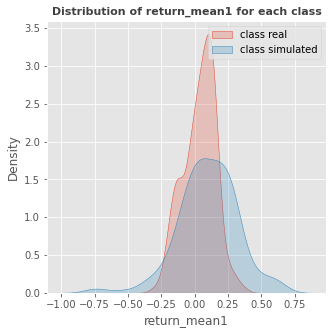

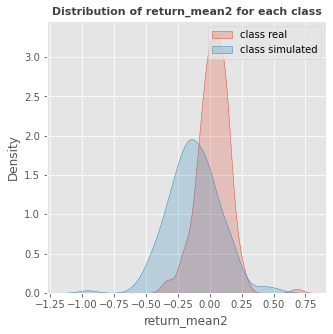

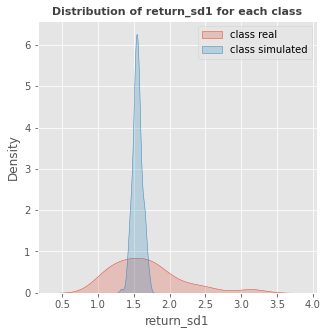

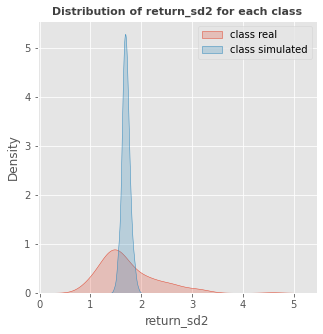

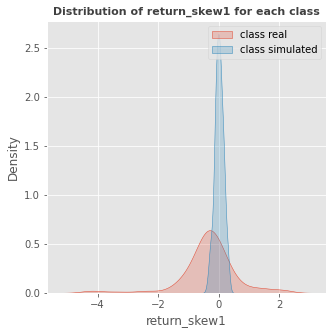

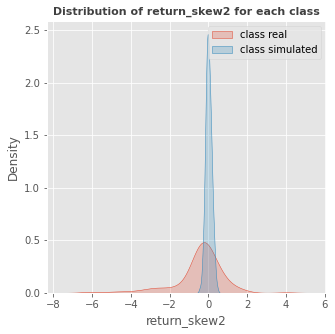

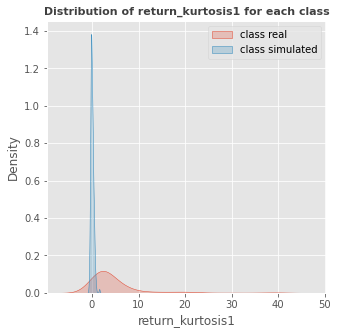

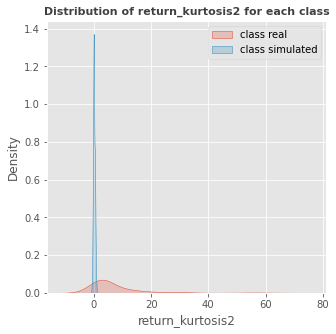

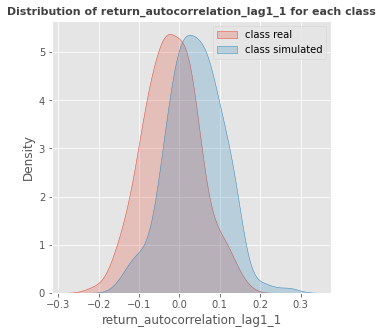

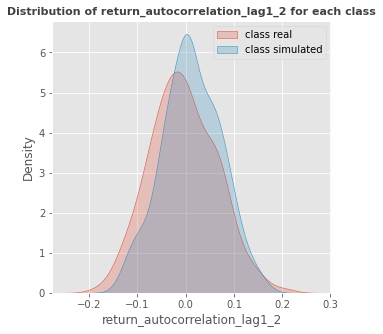

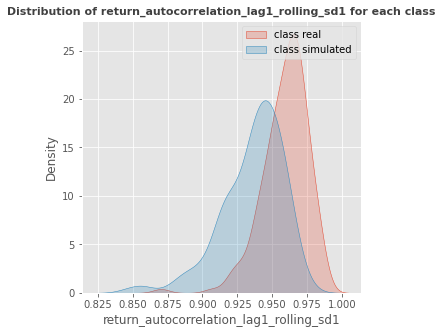

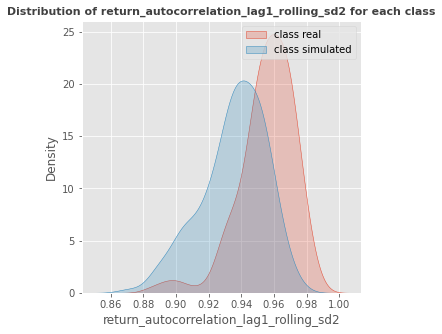

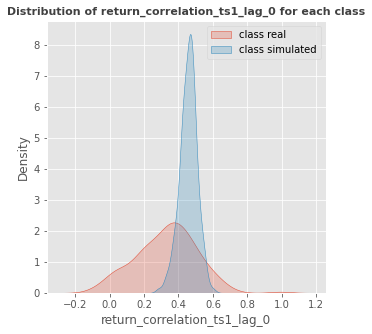

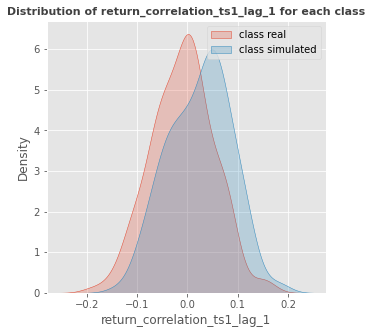

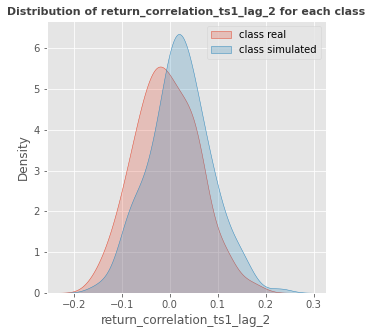

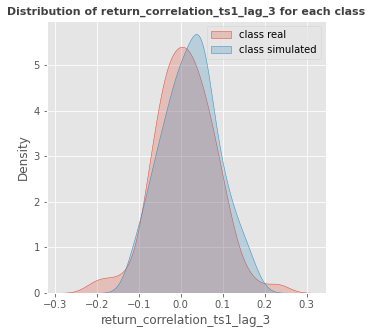

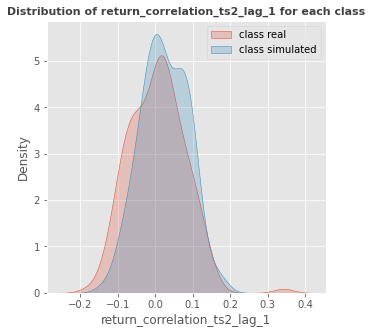

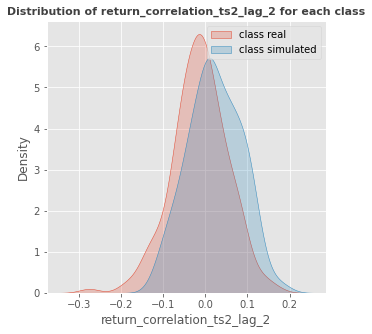

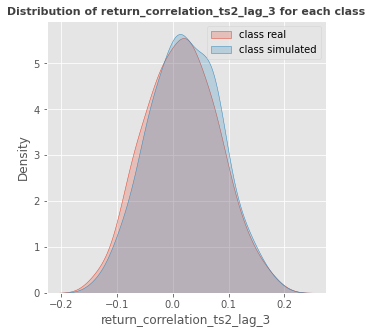

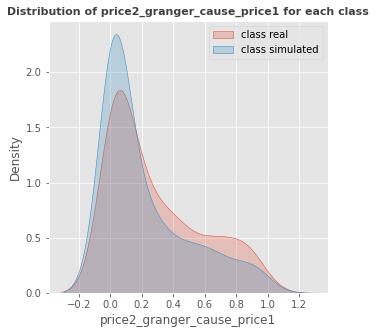

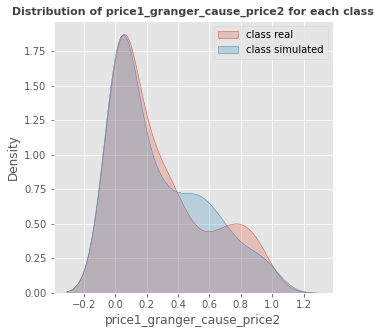

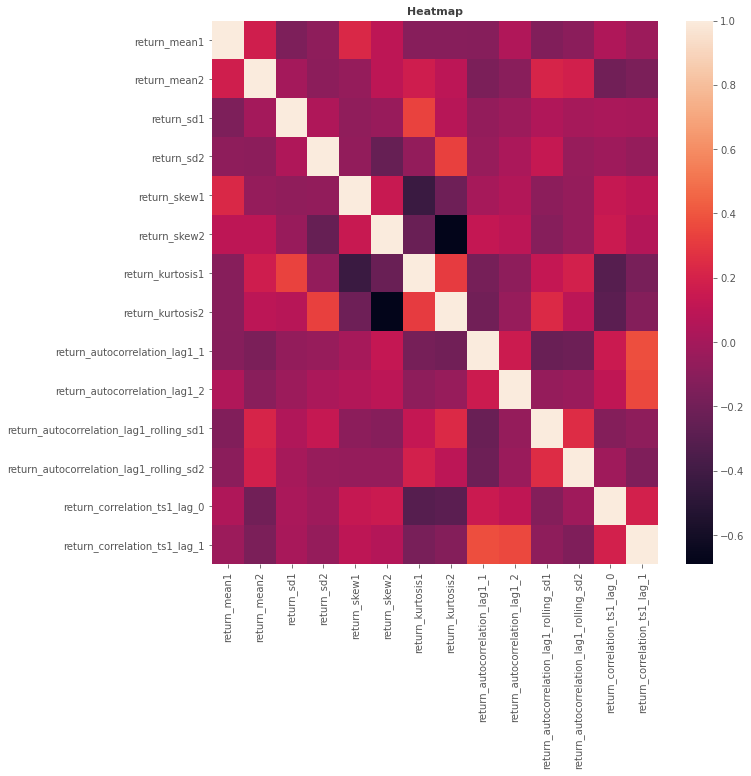

In [7]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_ou_log_prices = n_ou_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3],
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    xinit_vec=xinit_vec, T0=0, T=1, length=250)
    
    n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
    n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)
    
    n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou8/n_sim_ou_pair_prices.csv")
    n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou8/n_sim_ou_pair_returns.csv")


    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou8/n_sim_ou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou8/n_sim_ou_pair_prices.csv")

    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou8/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)



In [8]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9798657718120806, 0.9798657718120806, 1.0, 0.9865771812080537, 0.9932885906040269]
0.9879194630872483
0.007826781066906433
